1. Plotting actual vs predicted using all data (fit NN to all data first)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the TensorBoard notebook extension.

%reload_ext tensorboard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import pickle
from pickle import load , dump
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns
import tensorboard
import copy
from PIL import Image
tensorboard.__version__

'2.7.0'

In [ ]:
MicroclimateData = pd.read_csv('/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Combined/summer_limited.csv')
WeatherStationData = pd.read_csv('/content/drive/Shareddrives/Microclimate-Building Energy/Data/NN_big_data/Combined/all_buildings_big.csv')

In [ ]:
# Function to split same percent for each unique data in df column
def split_unique(dataset, column, test_size):
  X_train2 = pd.DataFrame()
  X_test2 = pd.DataFrame()
  y_train2 = pd.DataFrame()
  y_test2 = pd.DataFrame()
  for i,C in enumerate(dataset[column].unique()):
    X = dataset[dataset[column] == C][['bldgname',
                                    'Air Temp', 
                                    'Abs Hum',
                                    'DSW Top', 
                                    'DSW North', 
                                    'DSW South', 
                                    'DSW East', 
                                    'DSW West', 
                                    'Shade North', 
                                    'Shade East', 
                                    'Shade West',
                                    'Shade South']]
    y = dataset[dataset[column] == C]['CHWTON/SQFT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
    X_train2 = X_train2.append(X_train)
    X_test2 = X_test2.append(X_test)
    y_train2 = y_train2.append(y_train)
    y_test2 = y_test2.append(y_test)
  return X_train2, X_test2, y_train2, y_test2

# Split microclimate data 20% from each building for testing
X_train2, X_test2, y_train2, y_test2 = split_unique(MicroclimateData, 'bldgname', 0.2)
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)

# Check number of points in each building
# Note: Biodesign C has less data than all other buildings in original data
# for i,C in enumerate(MicroclimateData['bldgname'].unique()):
#   print(C, ":", len(MicroclimateData[MicroclimateData['bldgname']==C]))

(6773, 12)
(11, 6773)
(1696, 12)


## Flow of Code:
#### 1. Read both datasets, and do data preparation: Scaling, One-hot Encoding
#### 2. For limited data, train  model on Temp, Hum, Dsw(4), Shade(4), Encoding input features (find hyperparameters analytically)
#### 3. For big data, train model on Temp, Hum, Encoding 
#### 4. Fine tune weather station model on microclimate data and compare performance
#### 5. Work on adding artificial features and dropout on microclimate model

In [ ]:
class NeuralNetwork():
    def __init__(self,activation_type, hidden_layers, loss, kernel_initializer, bias_initializer, data_type,epochs):
        self.activation_type = activation_type
        self.hidden_layers = hidden_layers
        self.loss = loss
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer 
        self.data_type = data_type
        self.epochs = epochs
        self.scaler = StandardScaler()

    def huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = tf.keras.backend.abs(error) < clip_delta
        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
        return tf.where(cond, squared_loss, linear_loss)
        
    def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
        return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))
    # Function to split same percent for each unique data in df column
    def split_unique(dataset, column, data_columns, test_size):
        X_train2 = pd.DataFrame()
        X_test2 = pd.DataFrame()
        y_train2 = pd.DataFrame()
        y_test2 = pd.DataFrame()
        for i,C in enumerate(dataset[column].unique()):
            X = dataset[dataset[column] == C][data_columns]
            y = dataset[dataset[column] == C]['CHWTON/SQFT']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
            X_train2 = X_train2.append(X_train)
            X_test2 = X_test2.append(X_test)
            y_train2 = y_train2.append(y_train)
            y_test2 = y_test2.append(y_test)
        return X_train2, X_test2, y_train2, y_test2
        
    def prepare_data(self, dataset, func):        
        #add artificial features
        dataset['Air Temp Squared'] =  dataset['Air Temp']**2
        dataset['Abs Hum Squared'] =  dataset['Abs Hum']**2
        dataset['Air Temp*Abs Hum'] =  dataset['Air Temp']* dataset['Abs Hum']
        MicroclimateData['Air Temp Squared'] =  MicroclimateData['Air Temp']**2
        MicroclimateData['Abs Hum Squared'] =  MicroclimateData['Abs Hum']**2
        MicroclimateData['Air Temp*Abs Hum'] =  MicroclimateData['Air Temp']* MicroclimateData['Abs Hum']
        if self.data_type == 'WeatherStation'  and (func == 'test' or func == 'train'):
            X = dataset[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = dataset['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'train':
            X = dataset[['bldgname',
                                  'Air Temp', 
                                  'Abs Hum',
                                  'Air Temp Squared',
                                  'Abs Hum Squared',
                                  'Air Temp*Abs Hum',
                                  'DSW Top', 
                                  'DSW North', 
                                  'DSW South', 
                                  'DSW East', 
                                  'DSW West', 
                                  'Shade North', 
                                  'Shade East', 
                                  'Shade West',
                                  'Shade South']]
            columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
                        'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
                       'DSW North', 'DSW South', 'DSW East','DSW West',
                       'Shade North', 'Shade East', 'Shade West', 'Shade South',]
            Y = dataset['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'test':
            X = dataset[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = dataset['CHWTON/SQFT']
        Y = Y.values.reshape(-1, 1)
        Y = self.scaler.fit_transform(Y)
        X = pd.get_dummies(X)
        StdSc2 = StandardScaler()
        X[columns] = StdSc2.fit_transform(X[columns])
#         X_train, X_test, y_train, y_test = self.split_unique(X, 'bldgname', columns, 0.2)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=0.2, 
                                                            random_state=20)
        return X_train, X_test, y_train, y_test
    def define_model(self):
        if self.data_type == 'WeatherStation' :
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(20, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(30, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))           
        if self.data_type == 'Microclimate':
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
        model.compile( loss = self.loss, 
                      optimizer = 'adam')
        model.summary()
        return model
    def train(self, dataset):
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'train')
        self.model = self.define_model()
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            shuffle = True ,
                            callbacks=[tensorboard_callback])
    def fine_tune(self, dataset,alpha=0.001):
        self.model.trainable = True
        fine_tune_at = 2
        for layer in self.model.layers[:fine_tune_at]:
            layer.trainable =  False
        opt = Adam(learning_rate = alpha)    
        self.model.compile(loss=self.loss, 
                           optimizer=opt)
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'test')
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        print(X_train.shape)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            shuffle = True ,
                            callbacks=[tensorboard_callback])
        
        
    def plot_curve(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    def evaluate(self, dataset, data_type ):
        call_type = 'test'
        if data_type == self.data_type:
            call_type = 'train'
        _, X_test, _, y_test = self.prepare_data(dataset,call_type)
        Y_preds = self.model.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
        R2_score = metrics.r2_score(y_test, Y_preds)
        print("The RMSE score for test dataset of "+ data_type +" on model type:" + self.data_type + " model " +" is:", RMSE) 
        print("The R2 score for test dataset of "+ data_type +" on model type:" + self.data_type + " model " +" is:", R2_score)
        return Y_preds, y_test, X_test 

## Hyperparameter Tuning


In [ ]:
# eval_func = []
# max_R2 = -inf
# for func in activation_functions:
#     eval_func_layers = []
#     for hl in no_hidden_layers:
#         eval_func_loss = []
#         for loss in loss_functions:
#             model = define_model(func,hl,loss)
#             history = model.fit(X_train, Y_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
#             RMSE, R2 = evaluate(base_model, X_test, Y_test)
#             RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
#             eval_func_loss.append(R2)
#         eval_func_layers.append(eval_func_loss)
#     eval_func.append(eval_func_layers)
# print(eval_func)   
# tab = pd.DataFrame(eval_func, activation_functions, no_hidden_layers_headings,loss_functions_headings)
# print(tab)

def tune_multiple_buildings():
    activation_functions = ['relu','elu','selu','leaky_relu']
    no_hidden_layers = [3,4,5]
    loss_functions = ['mean_squared_error','mean_absolute_error','huber_loss']
#     loss_functions_headings = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','huber_loss']
    ### Create dataframe and add building names ###
    rf_optimal_model = pd.DataFrame(columns = {"bldgname", "R2_score_bigdata_best","R2_score_limiteddata_best", 'Activation Function','No of hidden layers', 'Loss function' })

    for i in list(MicroclimateData['bldgname'].unique()):
        rf_optimal_model = rf_optimal_model.append({'bldgname': i}, ignore_index=True)
    rf_optimal_model.fillna(5)
    ### Train over all hyperparameters over all buildings ###
    Buildings = list(MicroclimateData['bldgname'].unique())
    for i in range(len(Buildings)):
        max = 0
        # drop na values if in dataframe
        building_name = Buildings[i]
        print("Find parameters for "+ building_name)
        optimal_hyperparameters=[]
        # Limited Data
        NN = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'Microclimate', 250)
        X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = NN.prepare_data(MicroclimateData.loc[MicroclimateData['bldgname'] == Buildings[i]],'train')
        for func in activation_functions:
            for hl in no_hidden_layers:
                for loss in loss_functions:
                    print("Results for hyperparameters:Activation Fn: "+ func+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                    Testmodel = NeuralNetwork( func, hl, loss, 'he_normal','he_normal', 'Microclimate', 250)
                    Testmodel.model = Testmodel.define_model()
                    history = Testmodel.model.fit(X_limited_train, Y_limited_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
                    Y_preds = Testmodel.model.predict(X_limited_test)
                    R2_base_model = metrics.r2_score(Y_limited_test, Y_preds) 
                    print("The R2 score for test dataset on Microclimate Data model " +" is:", R2_base_model)
                    if(R2_base_model>max):
                        max = R2_base_model
                        print("Updated hyperparameters for building: "+ building_name +"max_R2:"+str(max)+": Activation Fn: "+ str(func)+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                        rf_optimal_model["R2_score_limiteddata_best"][i]=R2_base_model
                        rf_optimal_model["Activation Function"][i]=func
                        rf_optimal_model["No of hidden layers"][i]=hl
                        rf_optimal_model["Loss function"][i]=loss
    rf_optimal_model = rf_optimal_model[["bldgname","R2_score_limiteddata_best", 'Activation Function','No of hidden layers', 'Loss function']]
    return rf_optimal_model
optimal_model_buildings = tune_multiple_buildings()
display(optimal_model_buildings)


In [ ]:
# Tune for combined dataset
def tune_combined():
    activation_functions = ['relu','elu','selu','leaky_relu']
    no_hidden_layers = [3,4,5]
    loss_functions = ['mean_squared_error','mean_absolute_error','huber_loss']
    rf_combined = pd.DataFrame(columns = {'Activation Function','No of hidden layers', 'Loss function' ,'R2_score_best','RMSE_score_best'})
    NN = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'Microclimate', 250)
    X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = NN.prepare_data(MicroclimateData,'train')
    
    for i in range(len(activation_functions)):
        rf_combined = rf_combined.append({'Activation Function': activation_functions[i]}, ignore_index=True)
    rf_combined.fillna(5)  

    
    for i in range(len(activation_functions)):
        R2_max = 0
        func = activation_functions[i]
        for hl in no_hidden_layers:
            for loss in loss_functions:
                print("Results for hyperparameters:Activation Fn: "+ func+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                Testmodel = NeuralNetwork( func, hl, loss, 'he_normal','he_normal', 'Microclimate', 250)
                Testmodel.model = Testmodel.define_model()
                history = Testmodel.model.fit(X_limited_train, Y_limited_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
                Y_preds = Testmodel.model.predict(X_limited_test)
                R2_base = metrics.r2_score(Y_limited_test, Y_preds)
                RMSE_base = np.sqrt(metrics.mean_squared_error(Y_limited_test, Y_preds))
                if(R2_base>R2_max):
                    R2_max = R2_base
                    rf_combined["Activation Function"][i]=func
                    rf_combined["No of hidden layers"][i]=hl
                    rf_combined["Loss function"][i]=loss
                    rf_combined["R2_score_best"][i]=R2_base
                    rf_combined["RMSE_score_best"][i]=RMSE_base
        rf_combined = rf_combined[['Activation Function','No of hidden layers', 'Loss function', 'R2_score_best','RMSE_score_best']]
    return rf_combined
best_hyperparameters = tune_combined()   
display(best_hyperparameters)                 

Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                780       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2050      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 4,121
Trainable params: 4,121
Non-trainable params: 0
_________________________________________________________________
Results for hyperpar

Activation Function No of hidden layers  ... R2_score_best RMSE_score_best
0                relu                   4  ...      0.986183        0.119363
1                 elu                   5  ...      0.984836        0.125044
2                selu                   4  ...      0.983457        0.130606
3          leaky_relu                   4  ...      0.985334        0.122973

[4 rows x 5 columns]

In [ ]:
max_value = best_hyperparameters['R2_score_best'].max()
max_index = max(best_hyperparameters.index[best_hyperparameters['R2_score_best']==max_value])

number_layers = best_hyperparameters['No of hidden layers'][max_index]
loss_func = best_hyperparameters['Loss function'][max_index]
act_func = best_hyperparameters['Activation Function'][max_index]

#Training the 2 models:

In [ ]:
Microclimate = MicroclimateData.loc[(MicroclimateData['Month'] == 7) & (MicroclimateData['Day'] == 1)]

In [ ]:
if __name__ == "__main__":
    # Train microclimate Model
    MicroclimateModel = NeuralNetwork('relu', 5, 'mean_squared_error', 'he_normal','he_normal', 'Microclimate', 250)
    MicroclimateModel.train(MicroclimateData)
    Y_preds_NN, y_test_NN, X_test_NN = MicroclimateModel.evaluate(MicroclimateData, 'Microclimate')
    # Train Weather Station Model
    WeatherStationModel = NeuralNetwork('relu', 5, 'mean_squared_error', 'he_normal','he_normal', 'WeatherStation', 100)
    WeatherStationModel.train(WeatherStationData)
    tempModel = NeuralNetwork('relu', 5, 'mean_squared_error', 'he_normal','he_normal', 'WeatherStation', 100)
    tempModel.train(WeatherStationData)
    _,_,_ = WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')
   


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 30)                780       
_________________________________________________________________
dense_193 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_194 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_195 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_196 (Dense)            (None, 50)                2050      
_________________________________________________________________
module_wrapper_38 (ModuleWra (None, 50)                0         
_________________________________________________________________
dense_197 (Dense)            (None, 1)               

##Parameter Tuning:

In [ ]:
 def ParameterTuning():
  l_rates = [0.001,0.00125,0.0015,0.00175,0.002,0.003,0.01]
  R2_max=0
  lr=0
  for a in l_rates:
    print("Learning rate: "+str(a))
    tempModel.fine_tune(MicroclimateData,alpha=a)   
    Y_preds, y_test, X_test = tempModel.evaluate(MicroclimateData, 'Microclimate')
    RMSE_fine_tune = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
    R2_fine_tune = metrics.r2_score(y_test, Y_preds)
    if R2_fine_tune>R2_max:
      lr=a
      R2_max=R2_fine_tune
  print(lr)  
  return lr


In [ ]:
 # Fine Tune and compare results on entire data
lr = ParameterTuning()
WeatherStationModel.fine_tune(MicroclimateData,lr)
Y_preds_TL, y_test_TL, X_test_TL = WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')
_,_,_ = WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')


Learning rate: 0.001
(6775, 16)
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.13006538133108336
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9835936973268503
Learning rate: 0.00125
(6775, 16)
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.1283633289880101
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9840202777830125
Learning rate: 0.0015
(6775, 16)
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.12778695391638628
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9841634594160343
Learning rate: 0.00175
(6775, 16)
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.12854815968880842
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9839742261624033
Learning rate: 0

##Generating dataframe for scores

In [ ]:
R2_NN = metrics.r2_score(y_test_NN, Y_preds_NN)
RMSE_NN = np.sqrt(metrics.mean_squared_error(y_test_NN, Y_preds_NN))
R2_TL = metrics.r2_score(y_test_TL, Y_preds_TL)
RMSE_TL = np.sqrt(metrics.mean_squared_error(y_test_TL, Y_preds_TL))


scores = { 'Model Name':['Microclimate Model','Weather Station Model'],
                                    'R2_score':[R2_NN , R2_TL],
                                    'RMSE_score':[RMSE_NN , RMSE_TL]}
rf_scores = pd.DataFrame(scores)                                    
display(rf_scores)

Model Name  R2_score  RMSE_score
0     Microclimate Model  0.986304    0.118839
1  Weather Station Model  0.982841    0.133016

## Plotting

Use this to return dummy variables to original columns example: df2 = undummify(df2) 

In [ ]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [ ]:
def plotResults(day=None,mnth=None,dataset=MicroclimateData):
  date_time = dataset[['Date_Time',
                        'Month',
                        'Day',
                        'Hour',
                        'Minute']]

  x1,x2,y1,y2 = MicroclimateModel.prepare_data(dataset,'train')

# Microclimate Model(NN)
  comb1 = [x1,x2]
  x1 = pd.concat(comb1)
  Y_preds_NN = MicroclimateModel.model.predict(x1)
  results_NN = undummify(x1).join(date_time)
  col = results_NN.pop('bldgname')
  results_NN.insert(0, 'bldgname', col)
  y1= np.concatenate((y1,y2))
  results_NN['Actual'] = MicroclimateModel.scaler.inverse_transform(y1)
  results_NN['Time'] = results_NN['Date_Time'].str[11:16]
  results_NN['Predicted'] = MicroclimateModel.scaler.inverse_transform(Y_preds_NN)

  x3,x4,y3,y4 = WeatherStationModel.prepare_data(dataset,'test')

#Transfer Learning Model(TL)
  comb2 = [x3,x4]
  x3 = pd.concat(comb2)
  Y_preds_TL = WeatherStationModel.model.predict(x3)
  results_TL = undummify(x3).join(date_time)
  col = results_TL.pop('bldgname')
  results_TL.insert(0, 'bldgname', col)
  y3= np.concatenate((y3,y4))
  results_TL['Actual'] = WeatherStationModel.scaler.inverse_transform(y3)
  results_TL['Time'] = results_NN['Date_Time'].str[11:16]
  results_TL['Predicted'] = WeatherStationModel.scaler.inverse_transform(Y_preds_TL)


# User input Building name

  Buildings = results_NN['bldgname'].unique()
#  for i in range(len(Buildings)):
#    print(i, Buildings[i])

# User input Month
#  print(np.sort(results_NN['Month'].unique()))
  if mnth == None:
    mnth = int(input("Enter the month from the list above: "))
  

  month_NN = results_NN.loc[results_NN['Month'] == mnth]
  month_TL = results_TL.loc[results_TL['Month'] == mnth]

# User input Day
#  print(np.sort(results_NN['Day'].unique()))
  if day == None:
    day = int(input("Enter the day from the list above: "))
  
    
  day_NN = month_NN.loc[month_NN['Day'] == day]
  day_TL = month_TL.loc[month_TL['Day'] == day]

  for bldg in Buildings:
    bldg_NN = day_NN.loc[results_NN['bldgname']==bldg]
    bldg_TL = day_TL.loc[results_TL['bldgname']==bldg]

    if len(bldg_NN) == 0 and len(bldg_TL)==0:
        print("Not any value for this date")
        break

    values_NN = bldg_NN.sort_values(by=['Time'])
    values_TL = bldg_TL.sort_values(by=['Time'])
    values_NN['MicroModel Predicted'] = values_NN['Predicted']
    values_TL['TL Model Predicted'] = values_TL['Predicted']


    ax = values_NN.plot(x='Time',y='Actual',grid = False, figsize = (8,8))
    values_NN.plot(x='Time',y='MicroModel Predicted',grid = False, figsize = (8,8),ax=ax)
    values_TL.plot(x='Time',y='TL Model Predicted',grid = False, figsize = (8,8),ax=ax)
    ind = values_NN.index
    string = values_NN['Date_Time'][ind[0]][0:10] +' '+ bldg
    ax.title.set_text(string)
    ax = ax.get_figure() 
    string = '/content/drive/MyDrive/EEE 511/Plots/'+string
    ax.savefig(string)
  

Not any value for this date
Not any value for this date


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

Not any value for this date


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

Not any value for this date


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

Not any value for this date


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

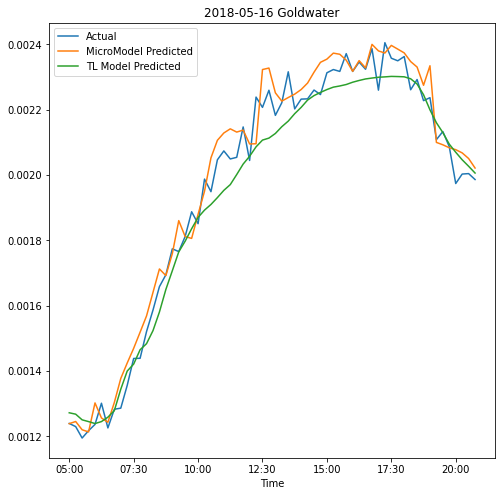

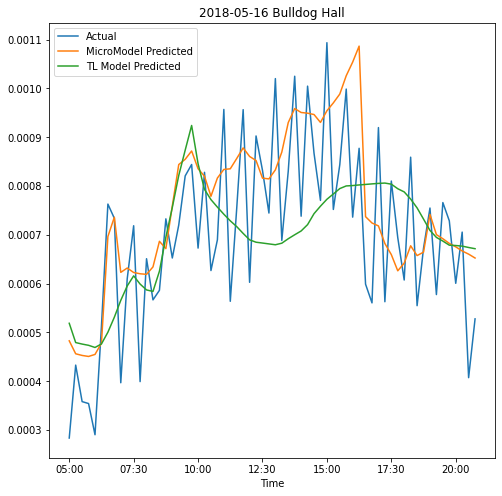

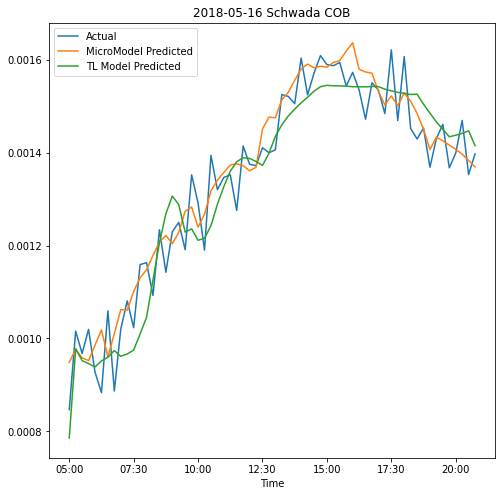

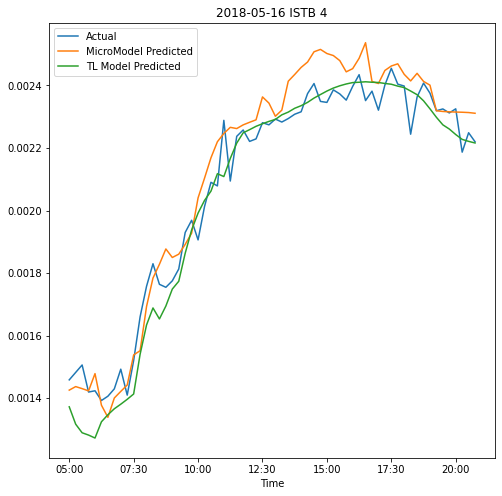

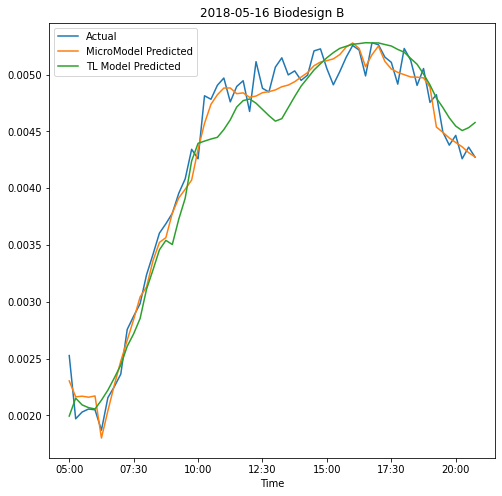

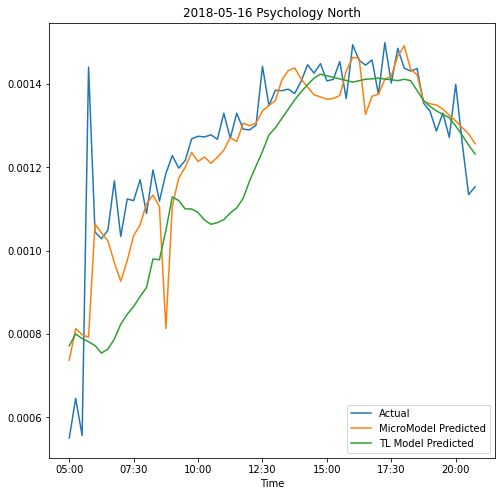

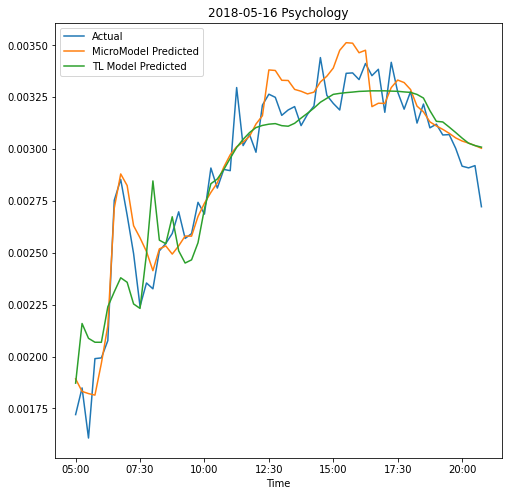

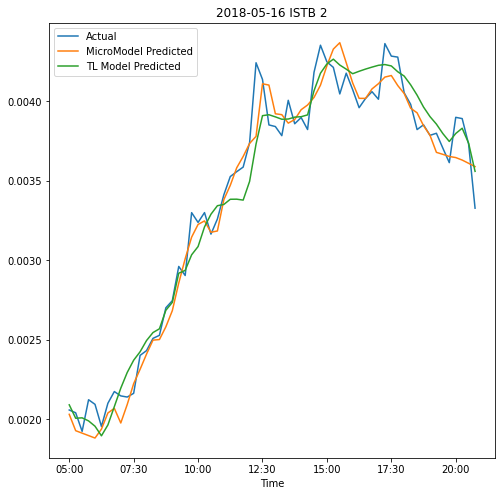

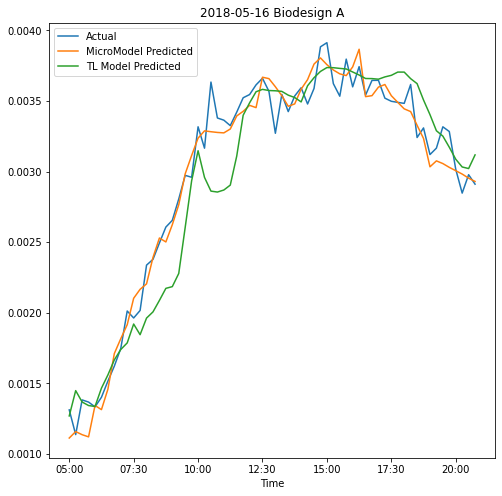

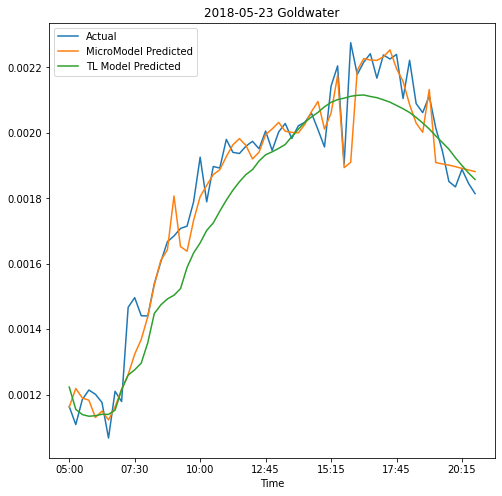

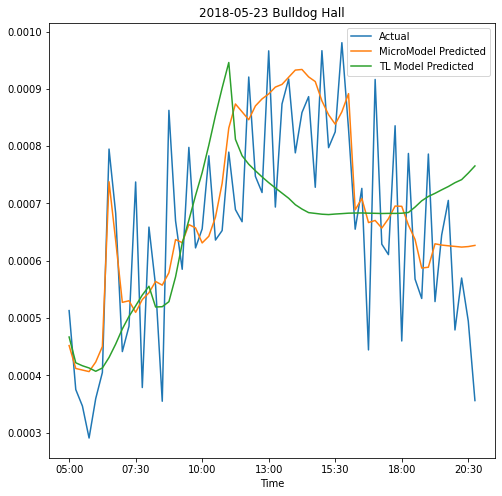

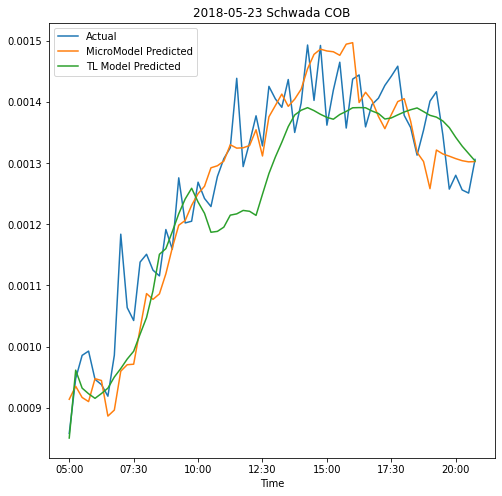

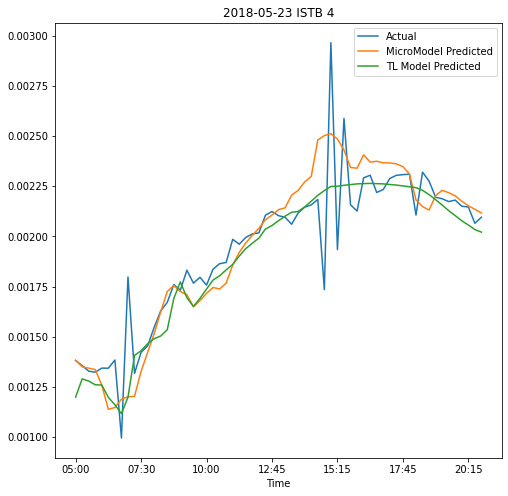

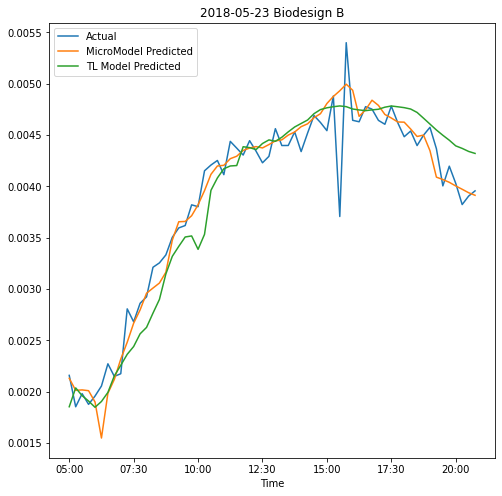

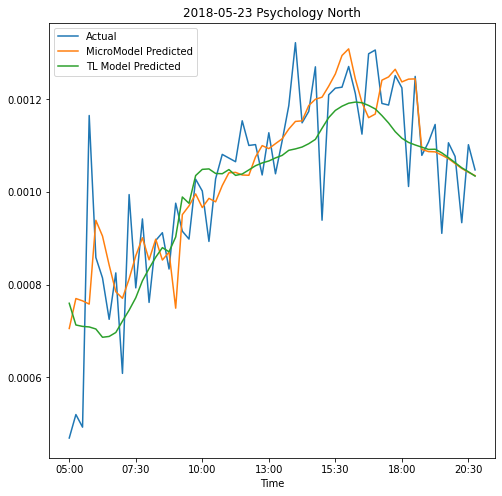

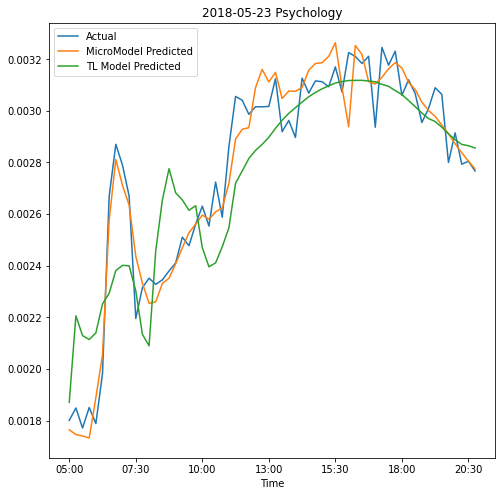

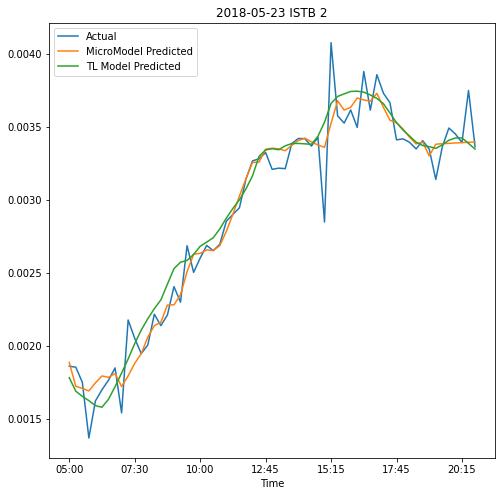

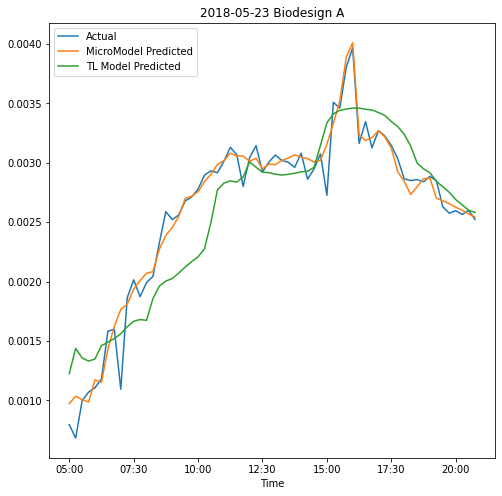

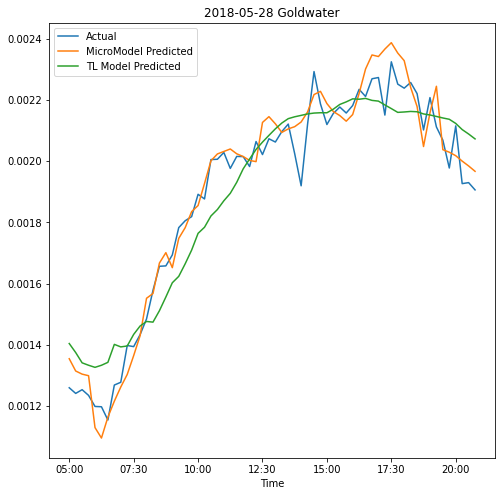

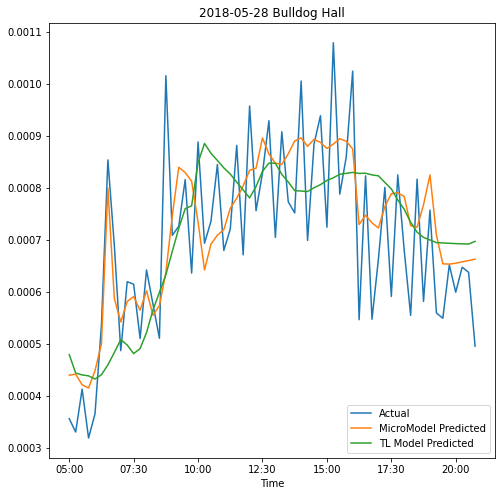

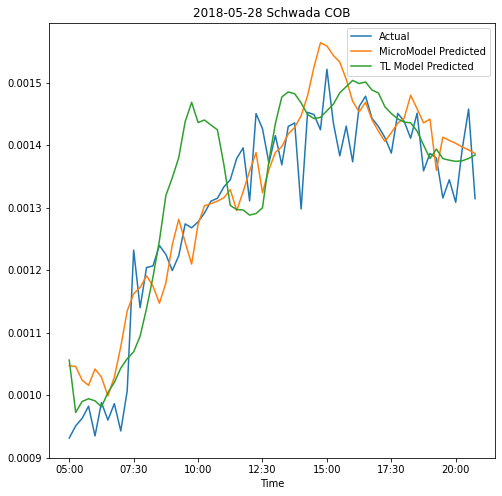

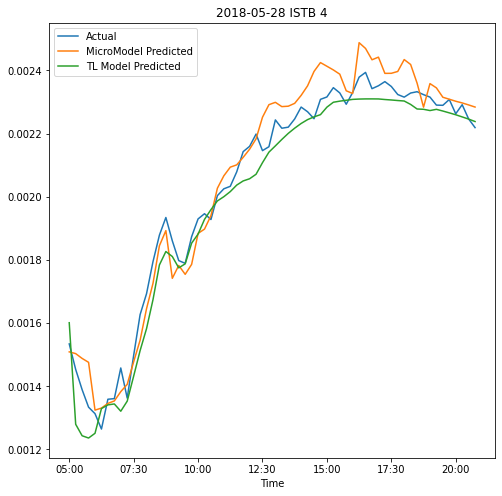

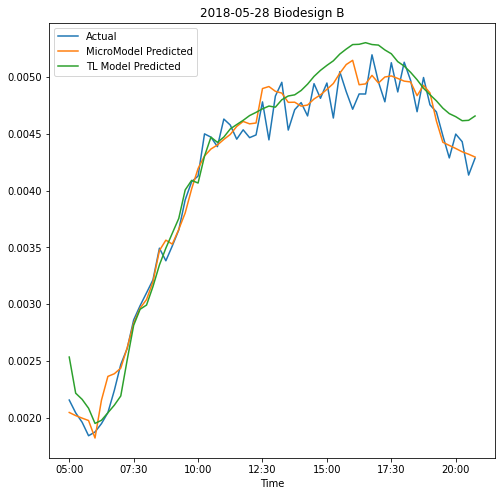

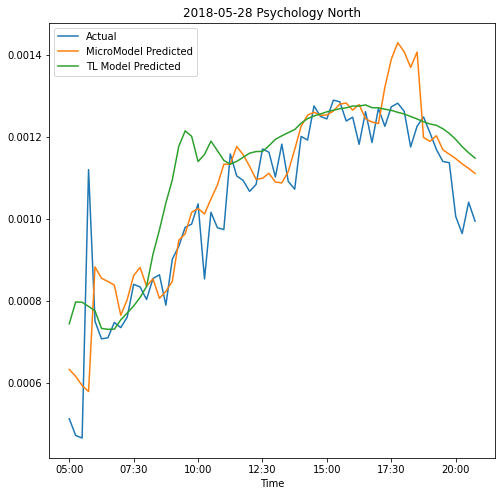

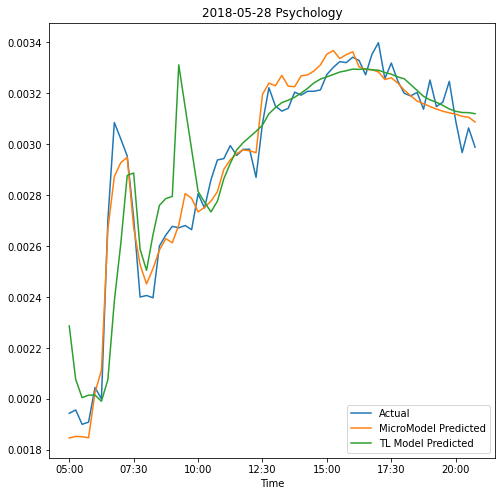

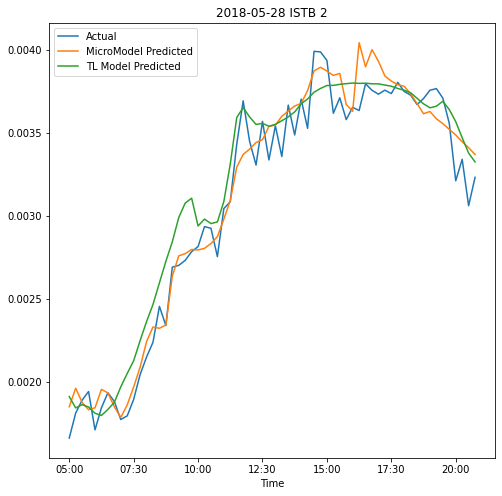

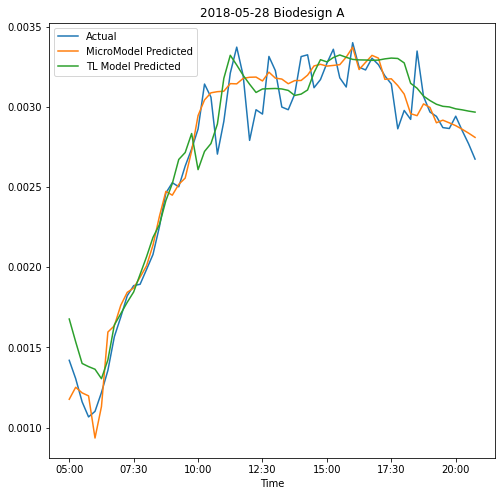

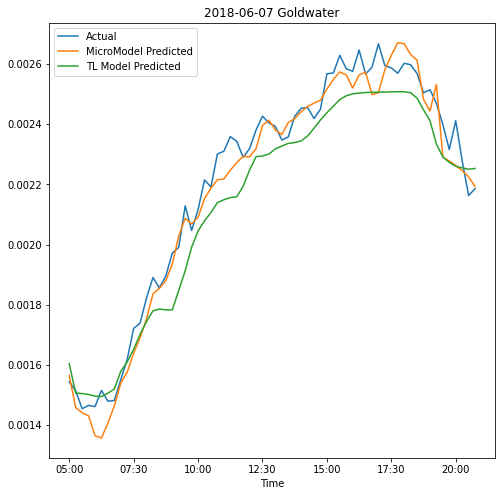

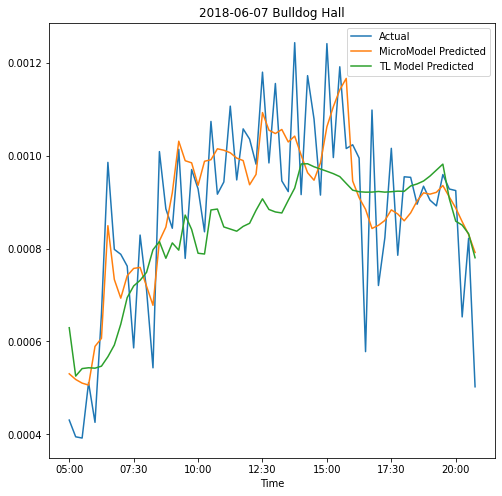

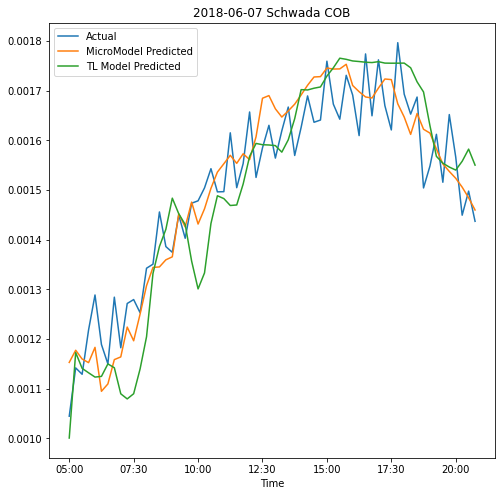

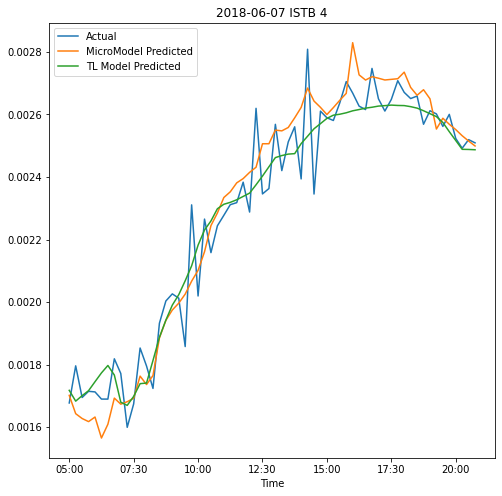

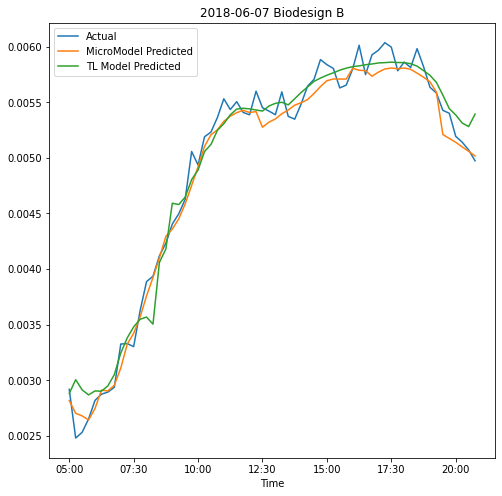

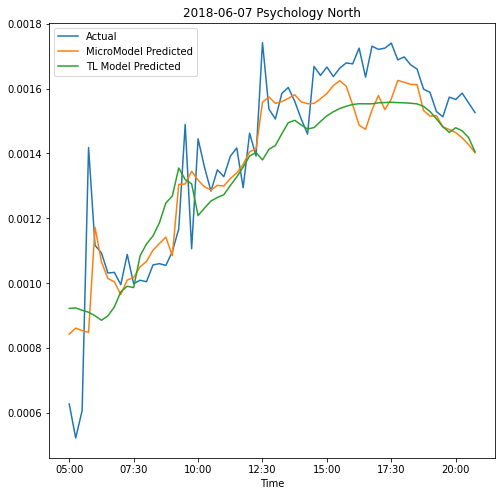

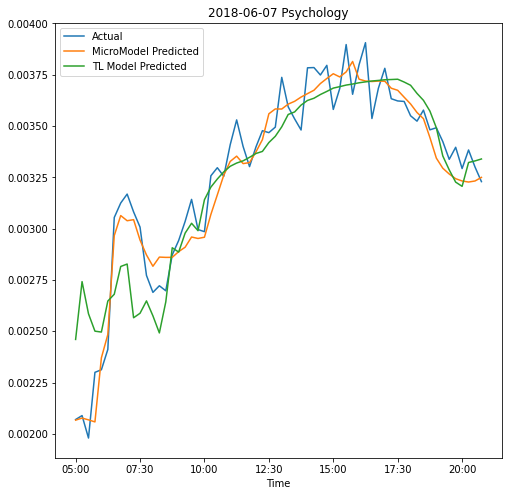

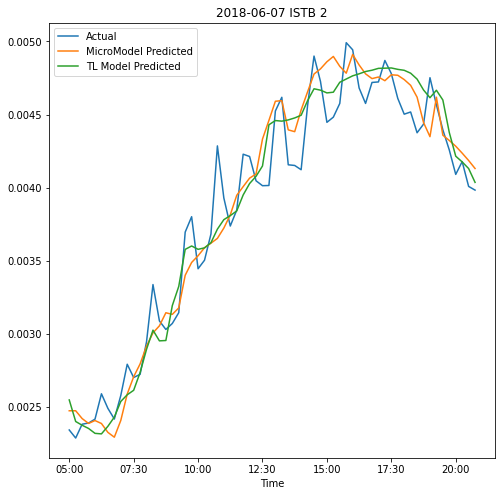

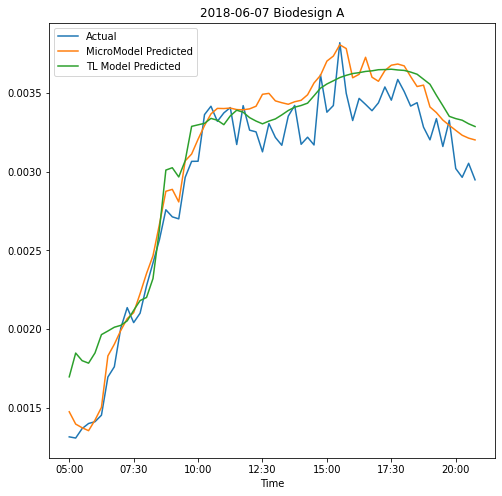

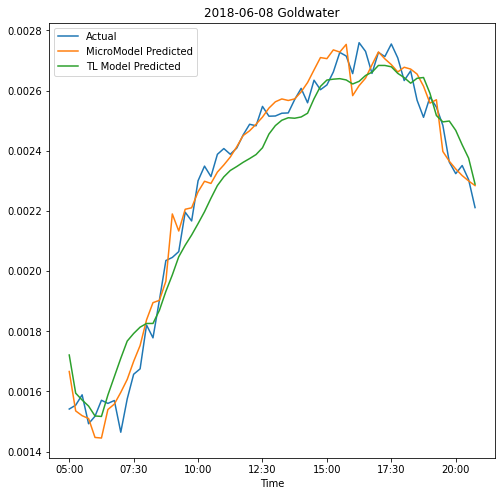

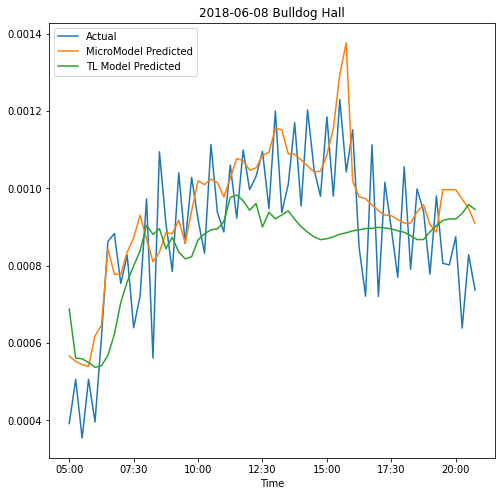

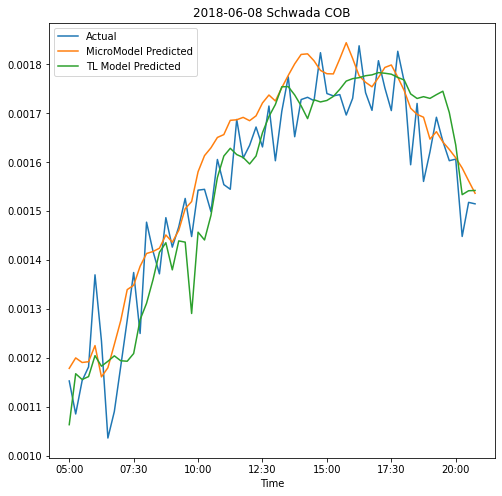

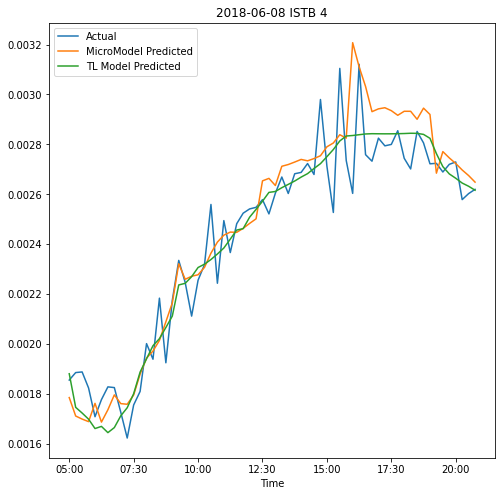

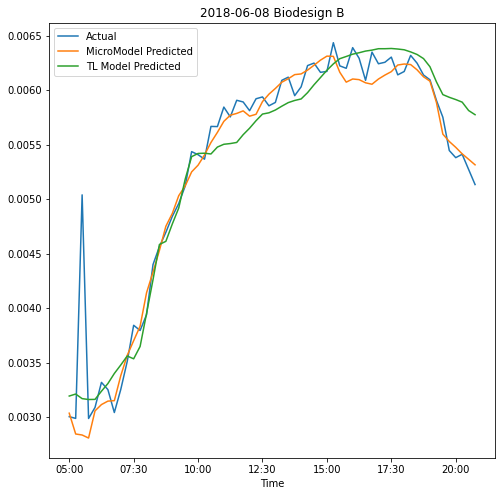

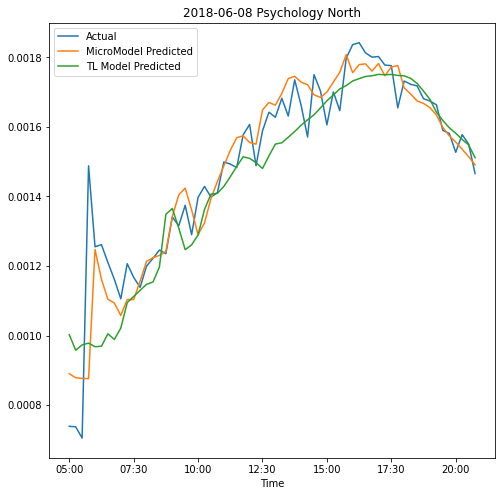

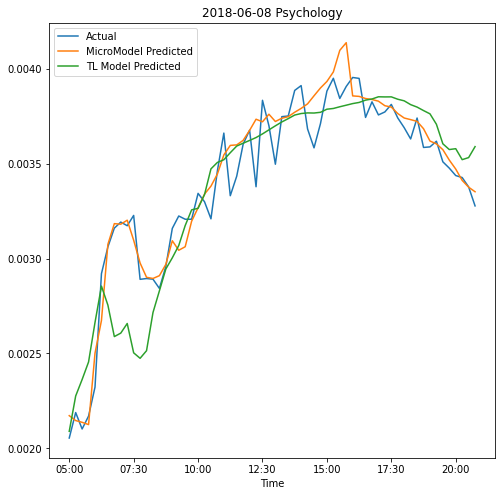

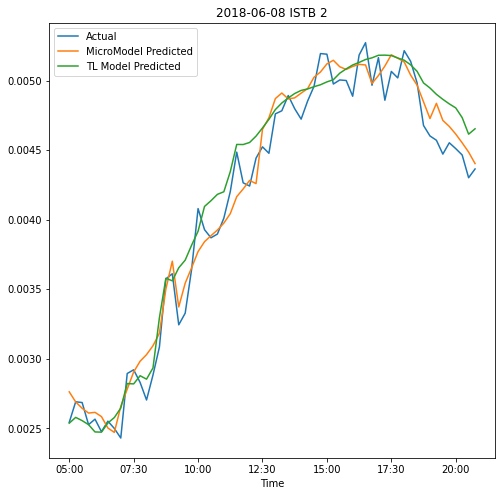

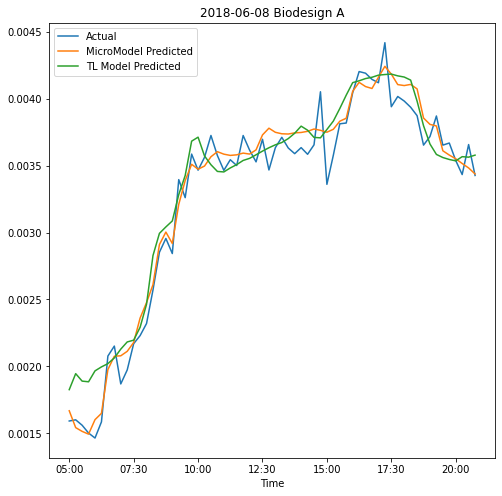

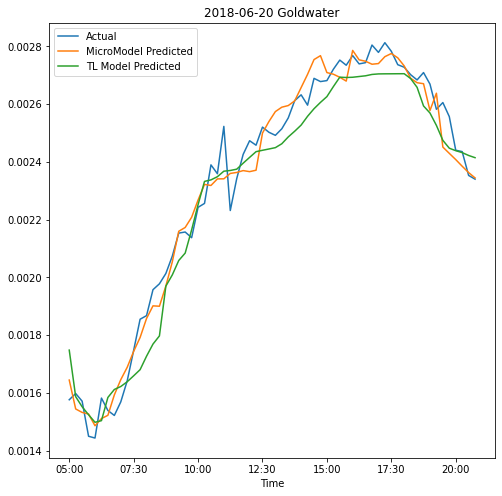

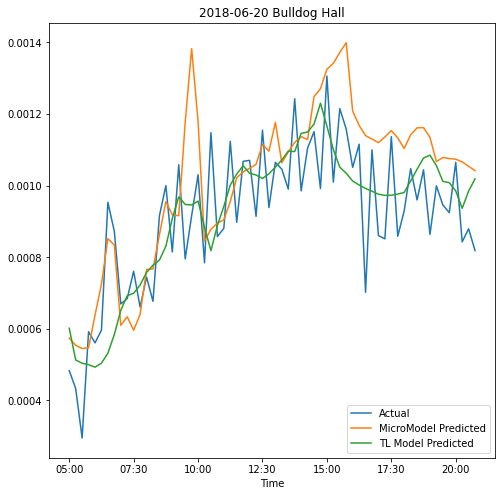

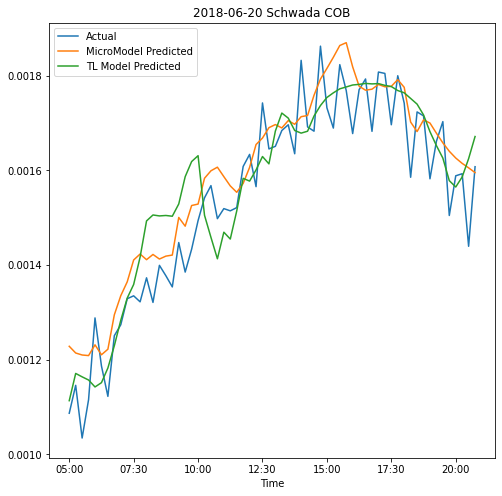

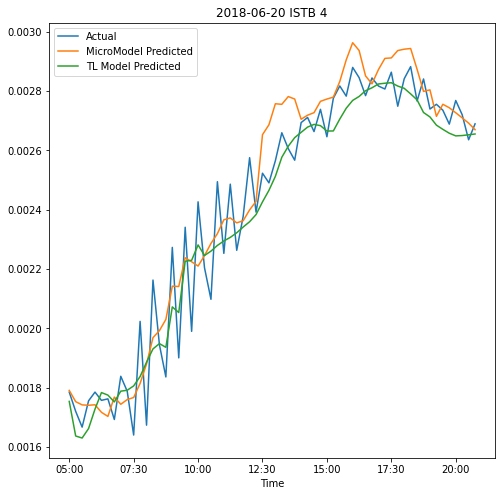

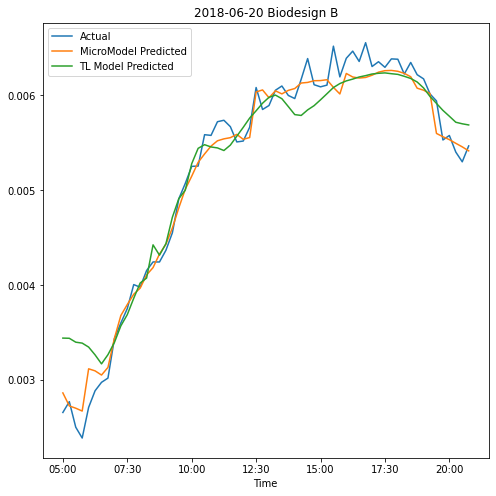

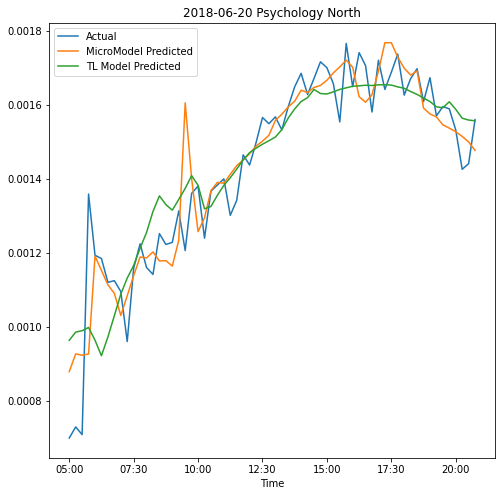

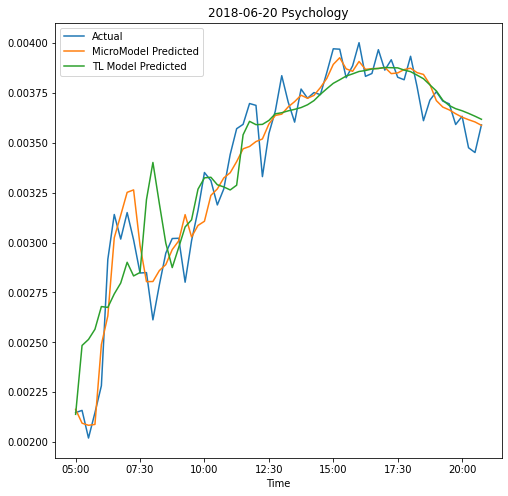

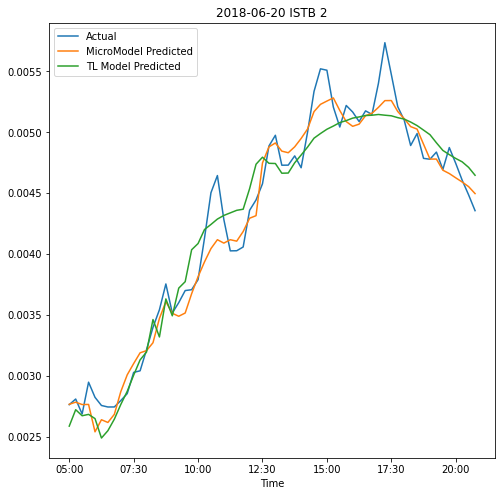

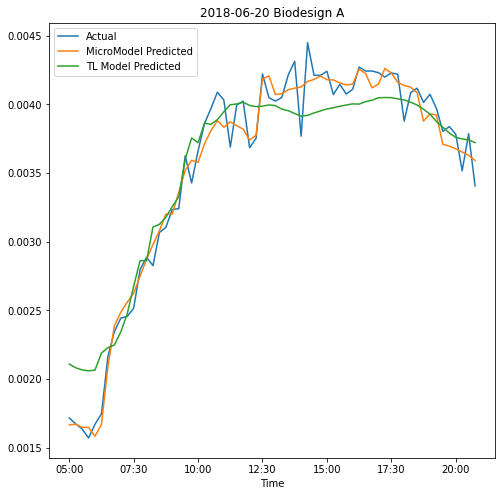

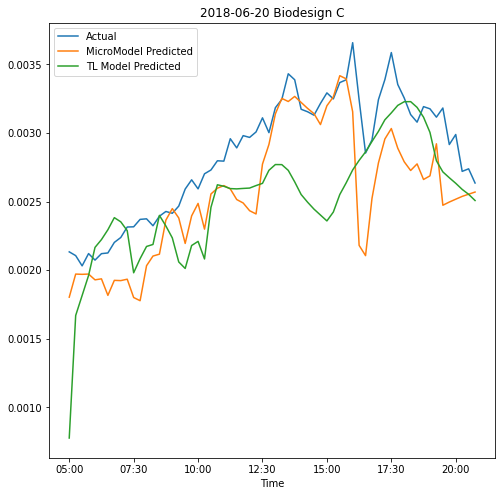

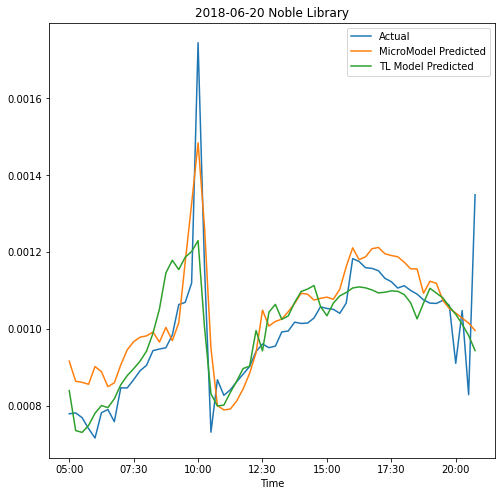

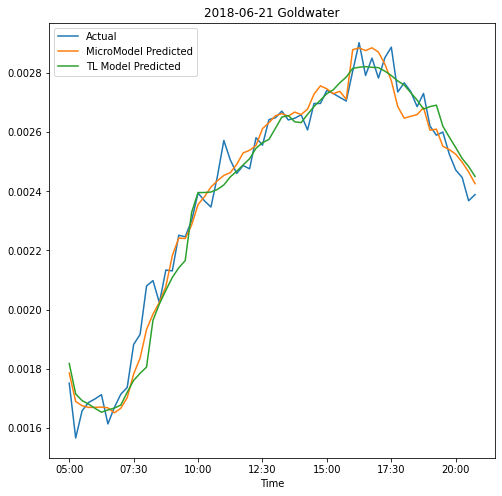

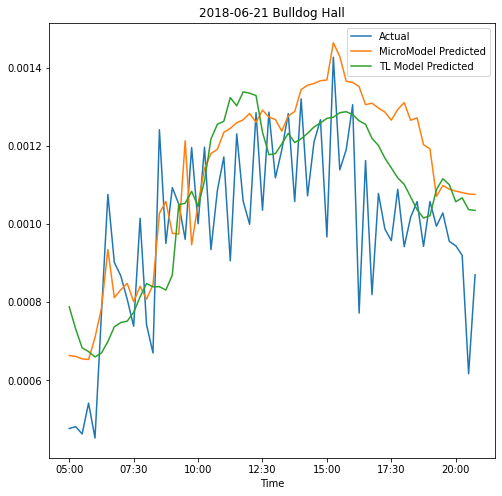

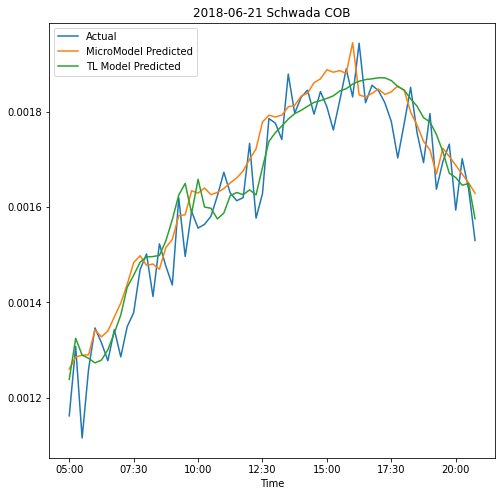

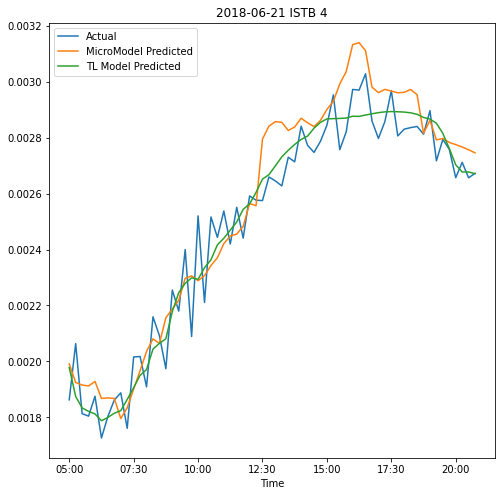

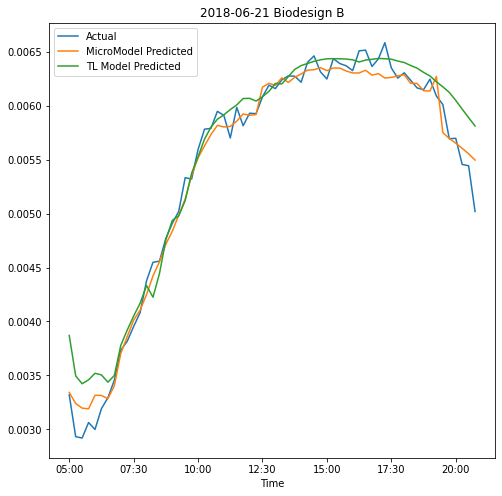

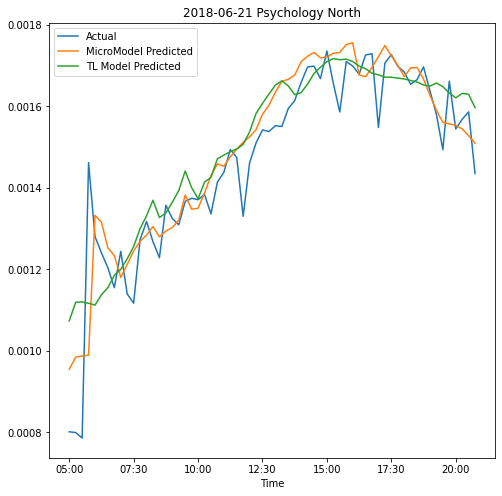

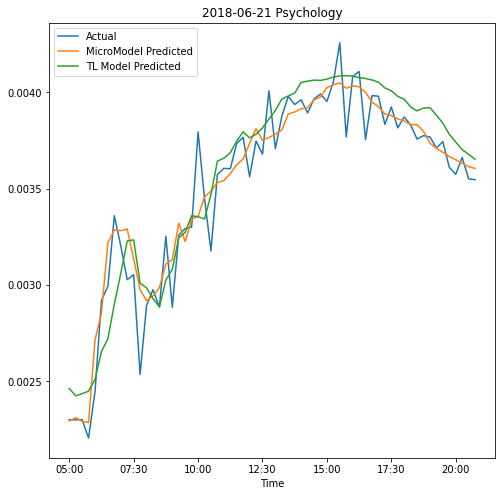

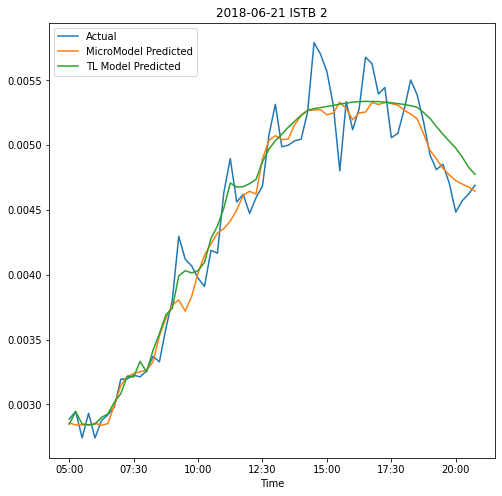

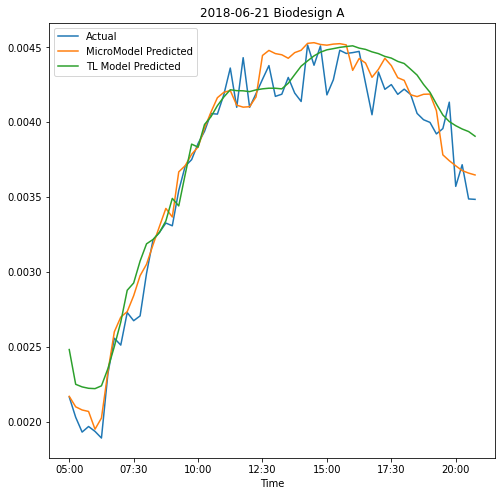

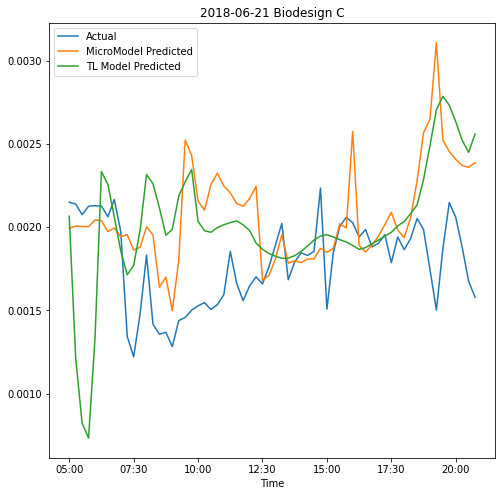

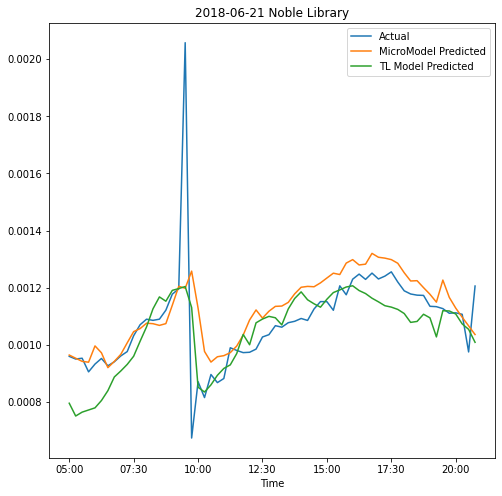

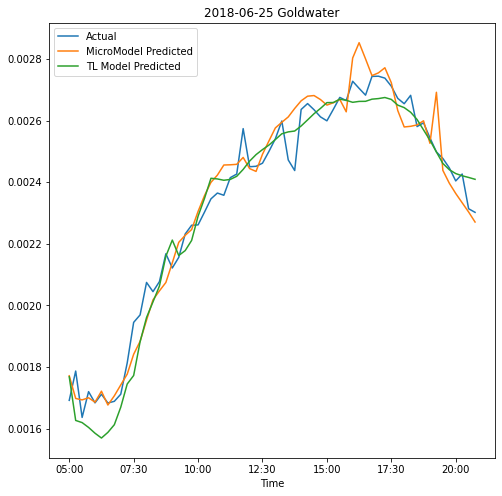

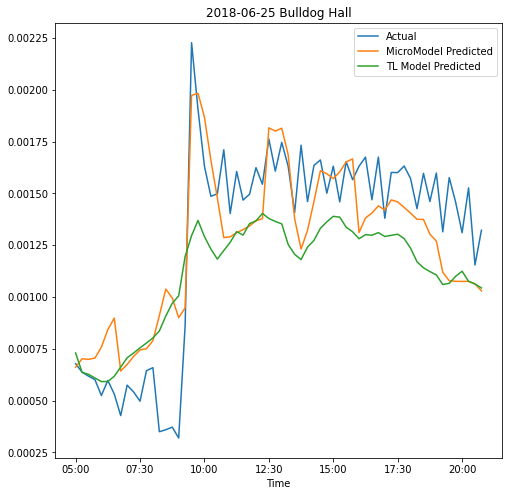

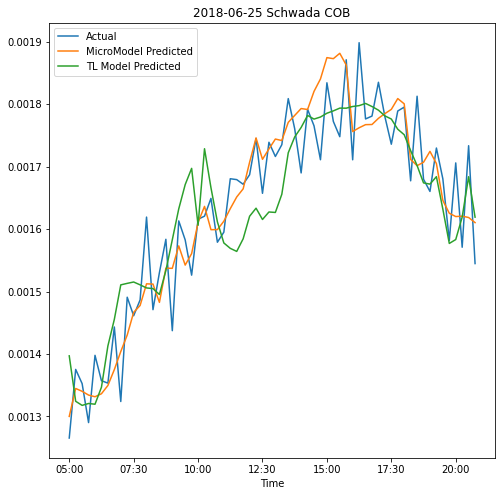

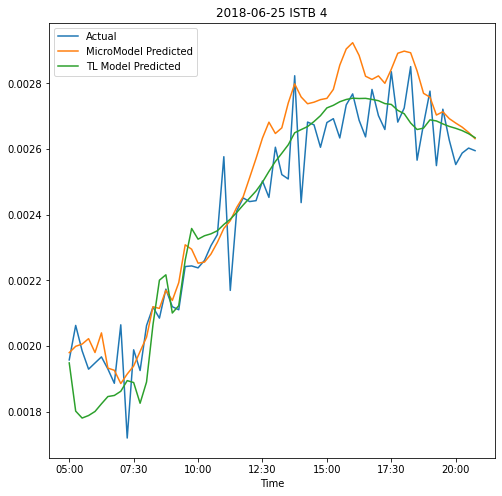

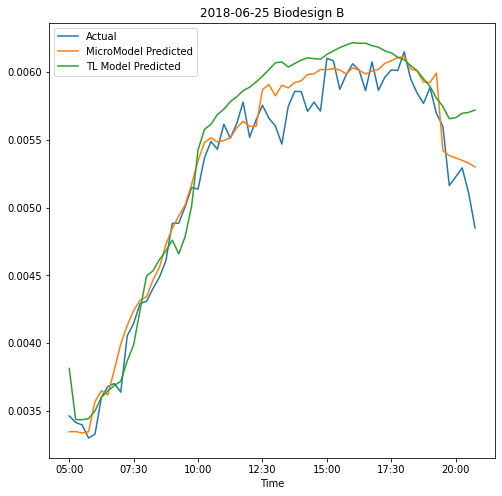

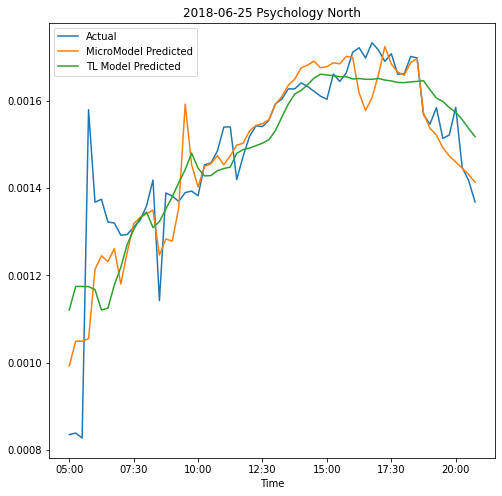

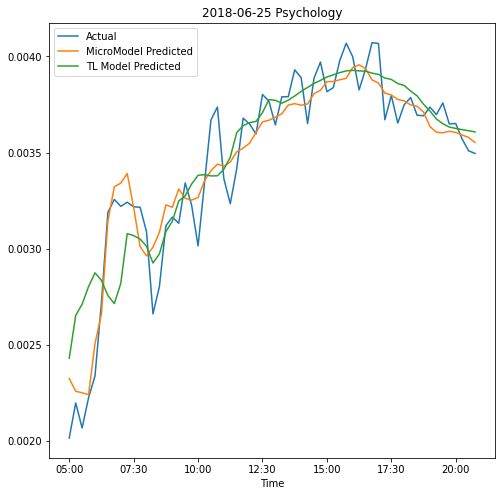

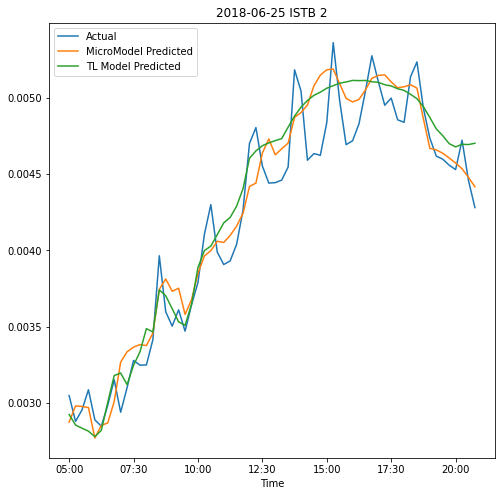

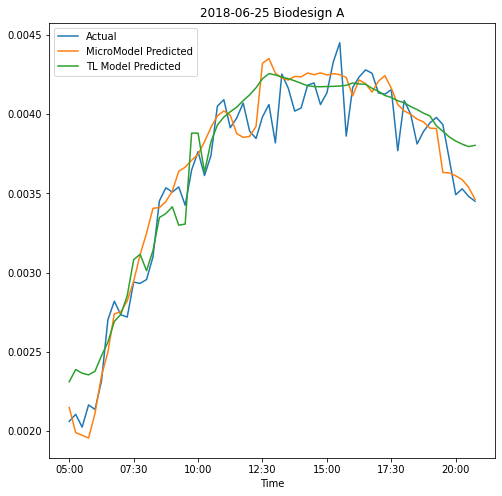

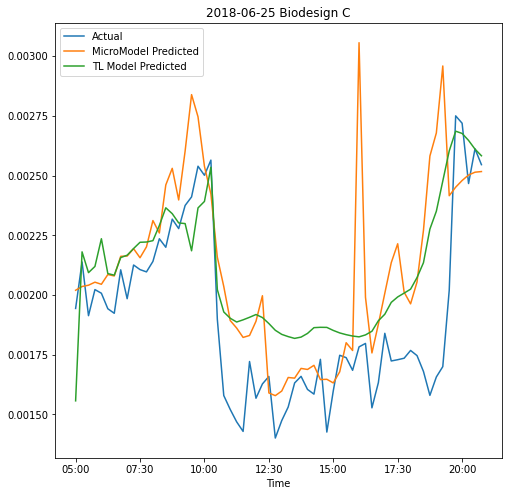

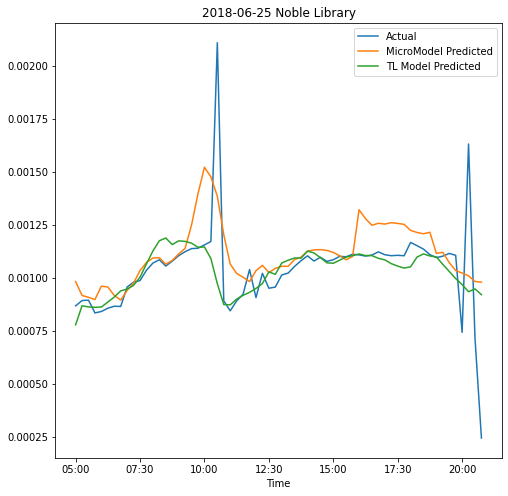

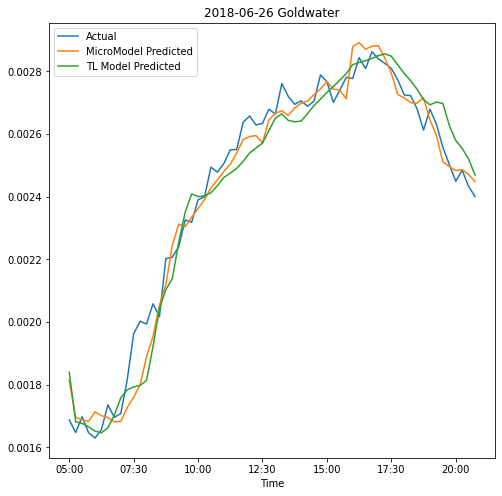

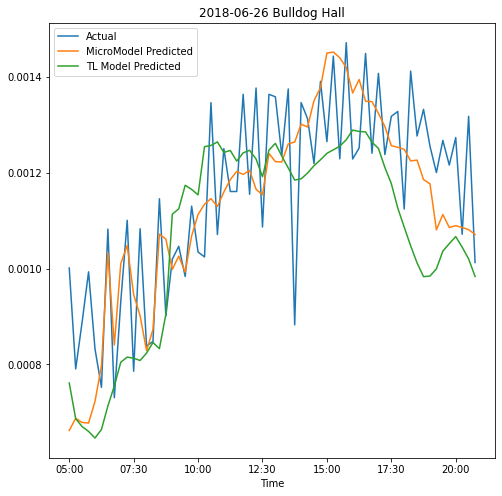

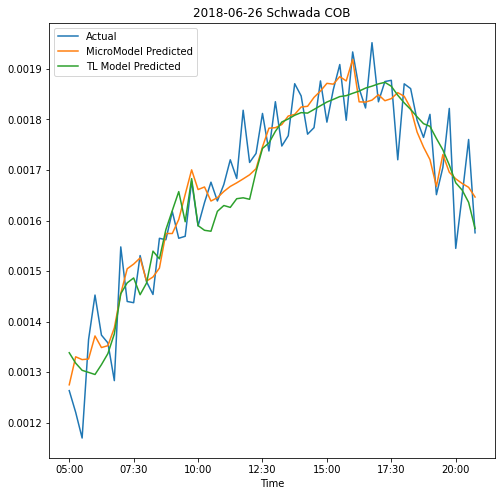

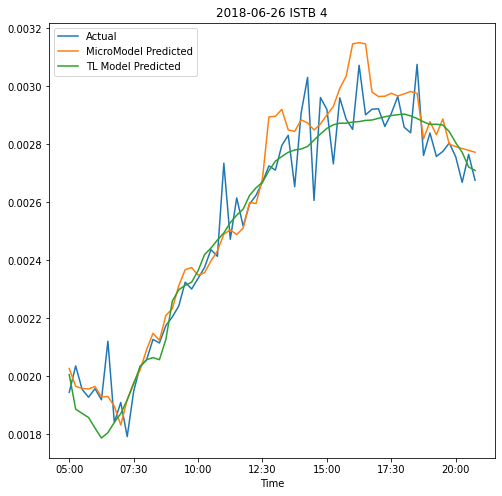

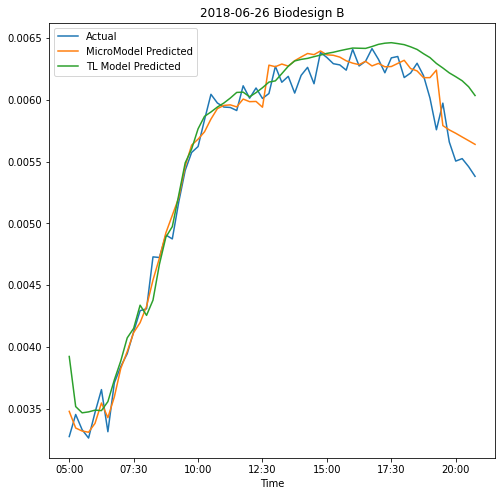

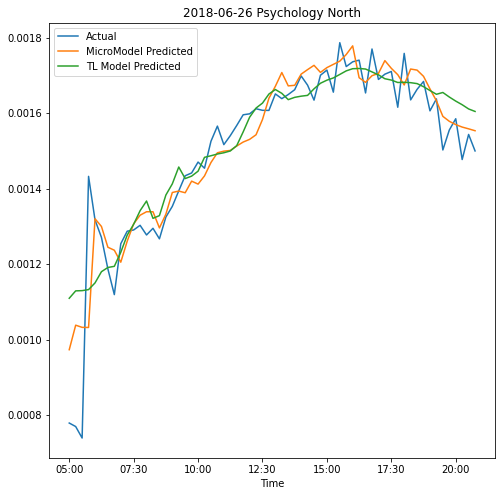

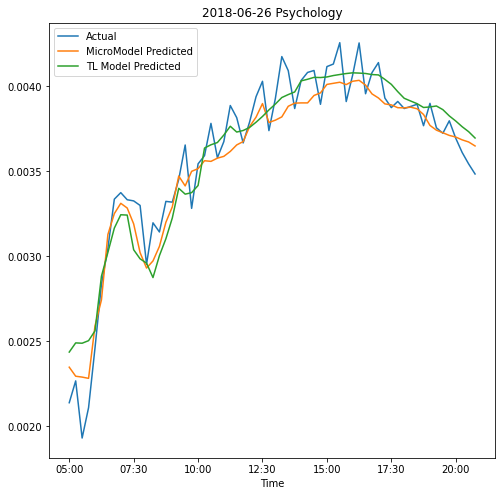

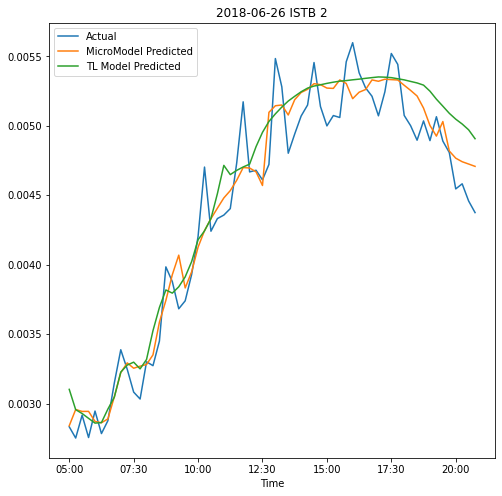

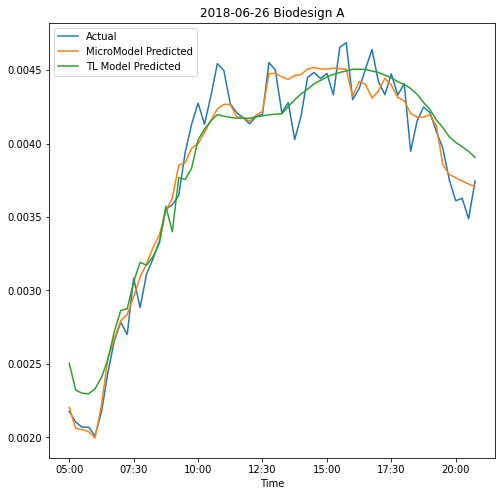

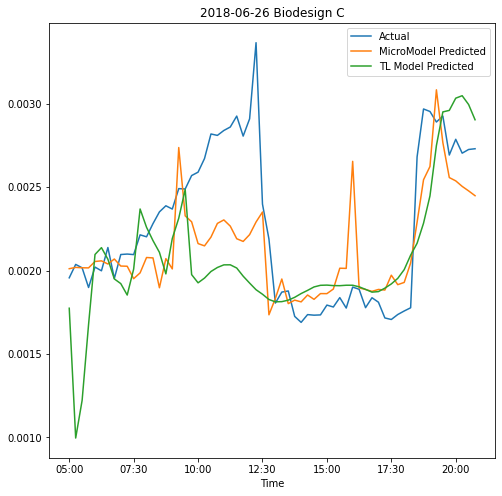

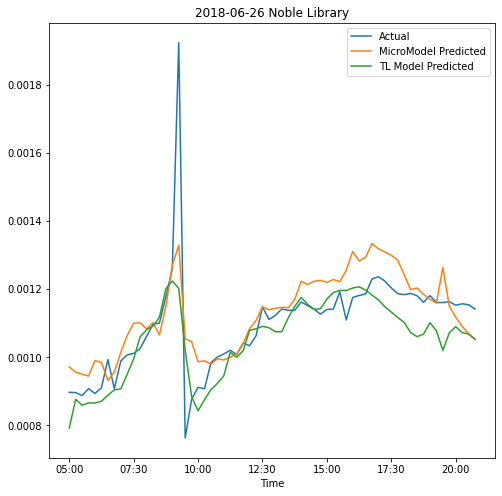

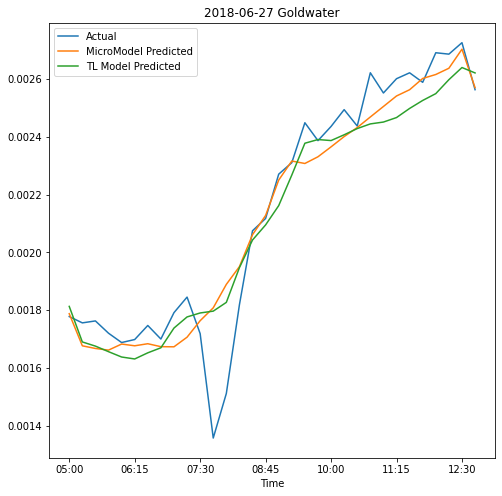

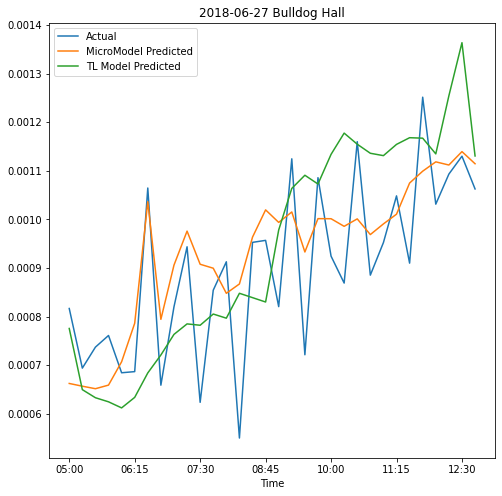

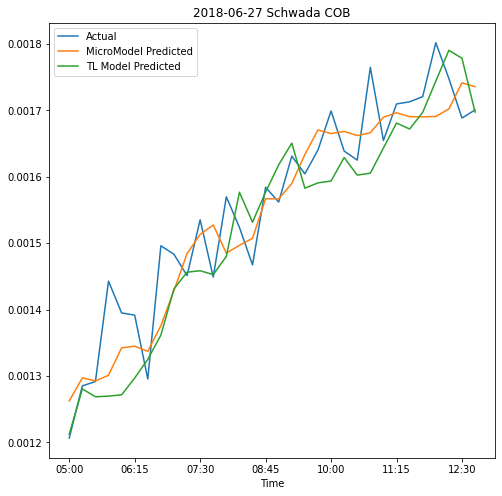

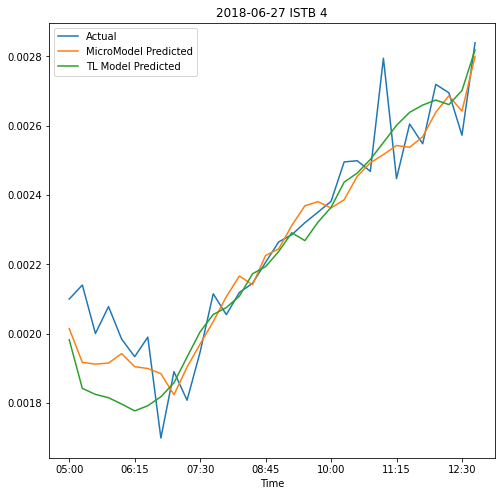

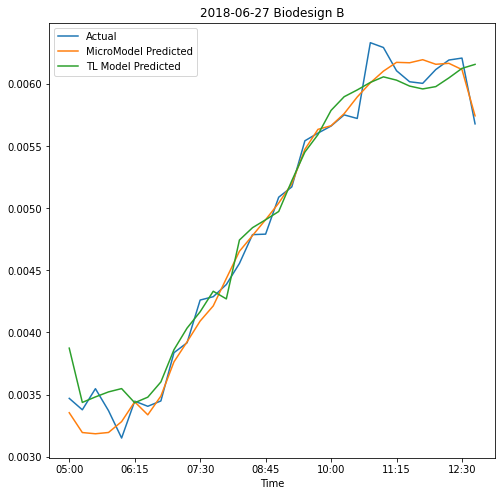

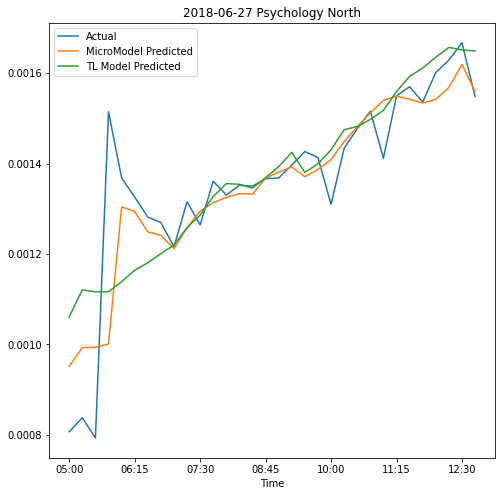

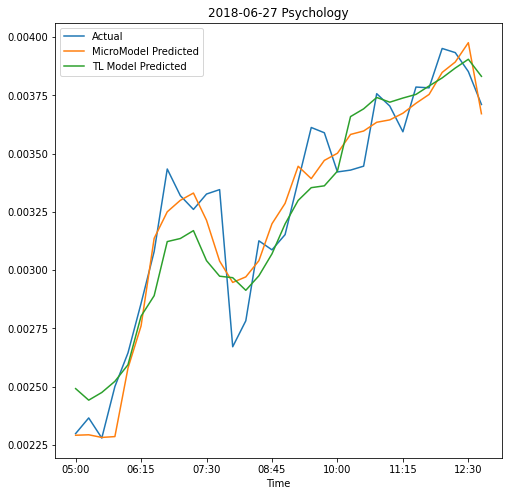

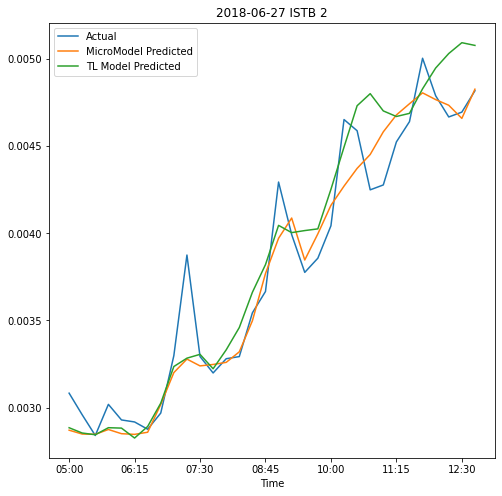

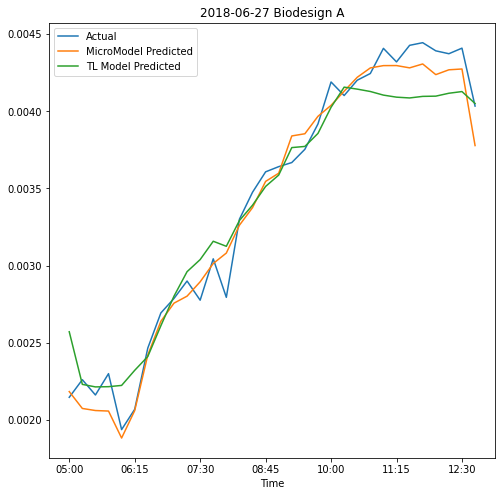

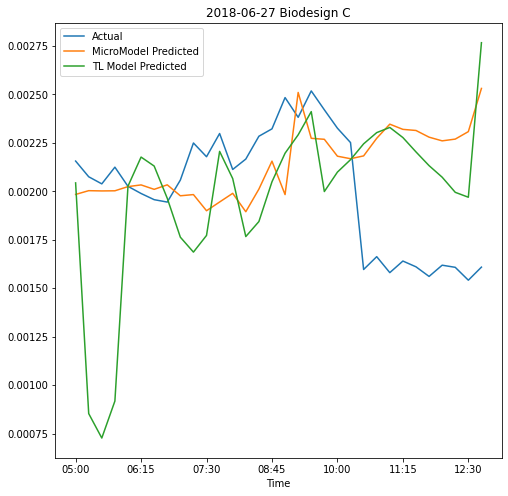

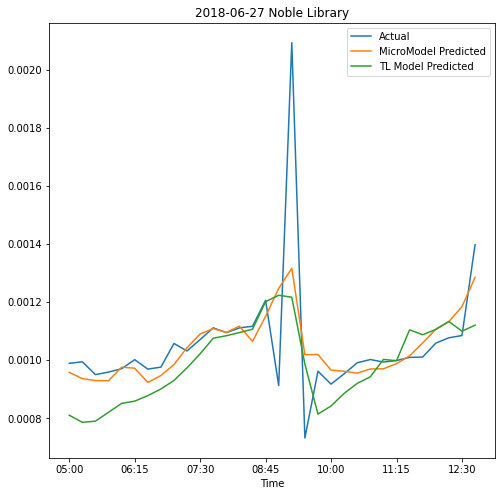

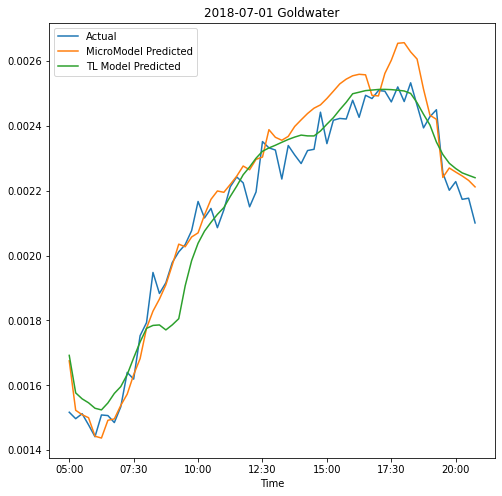

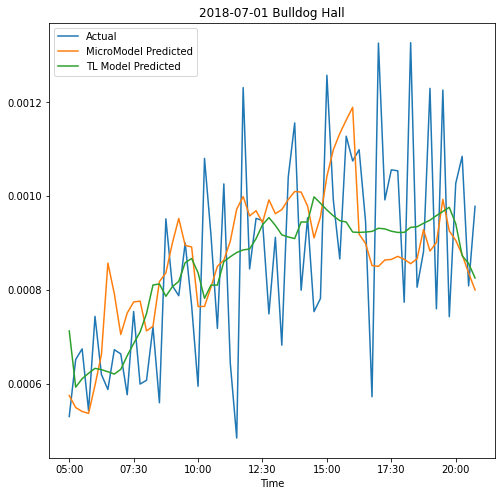

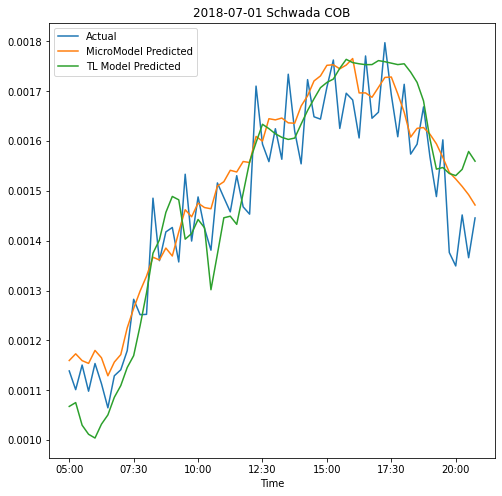

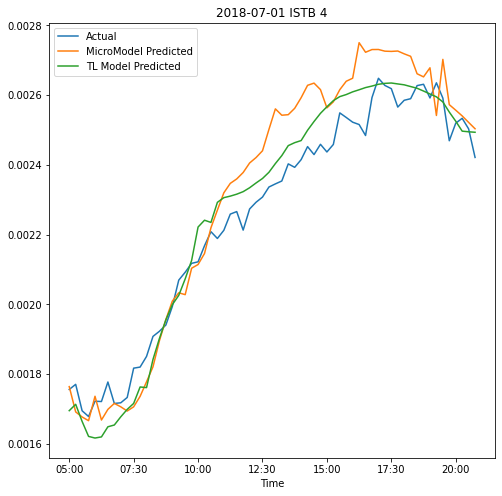

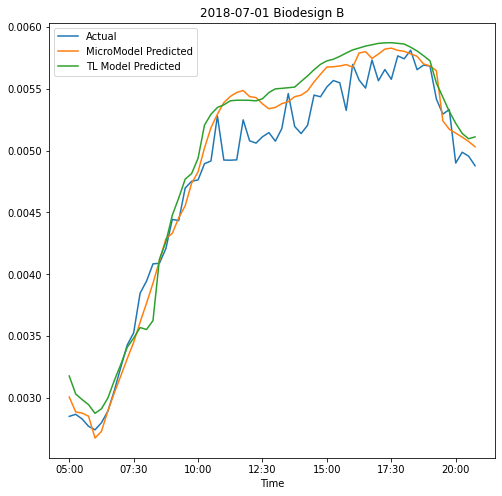

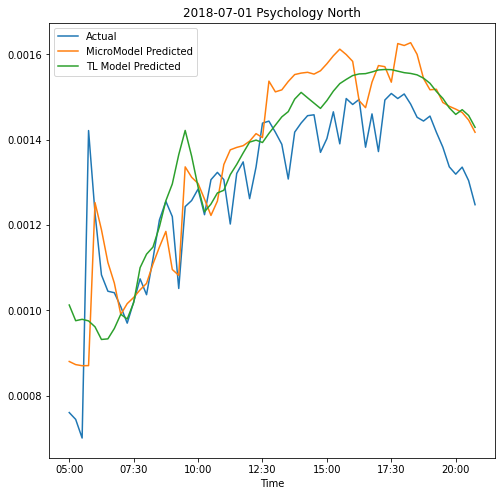

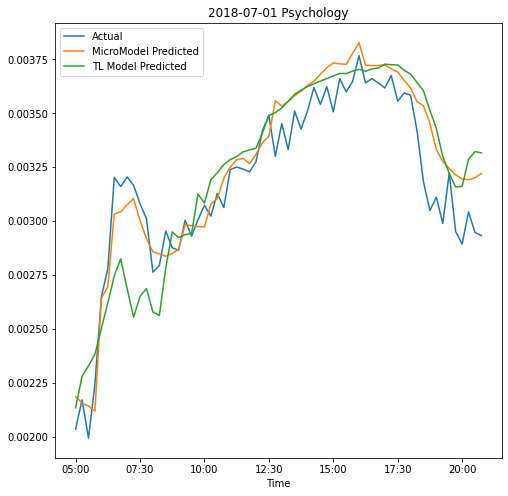

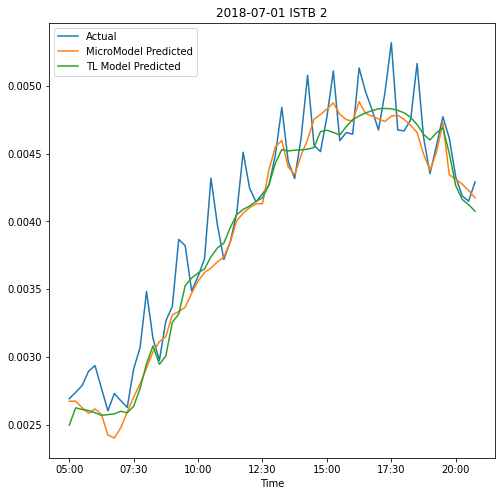

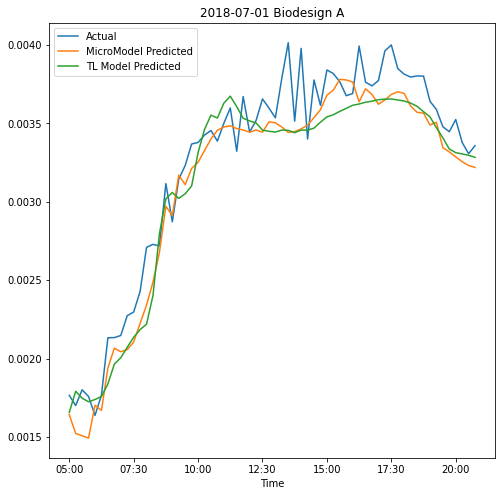

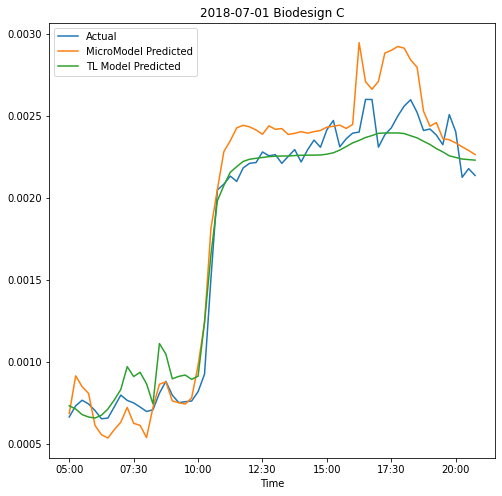

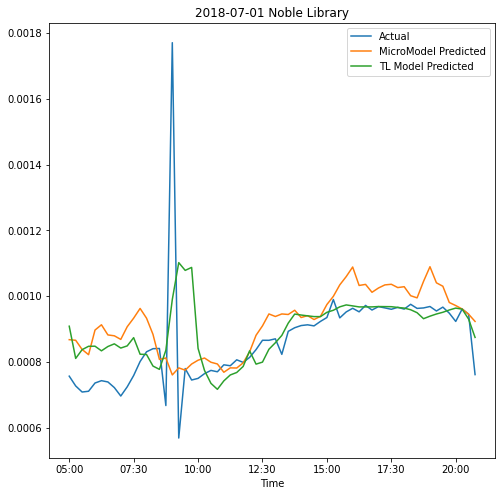

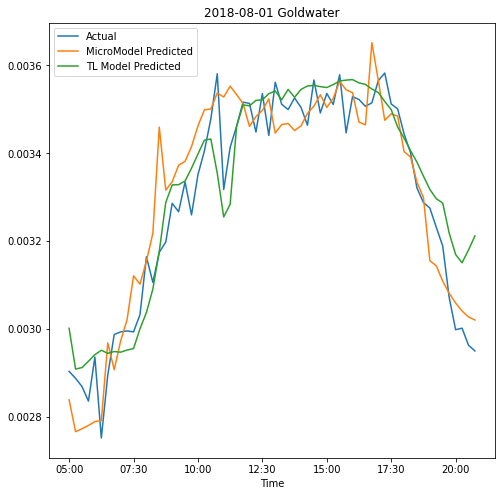

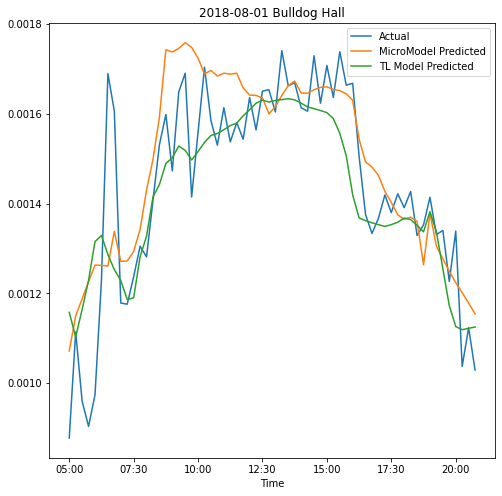

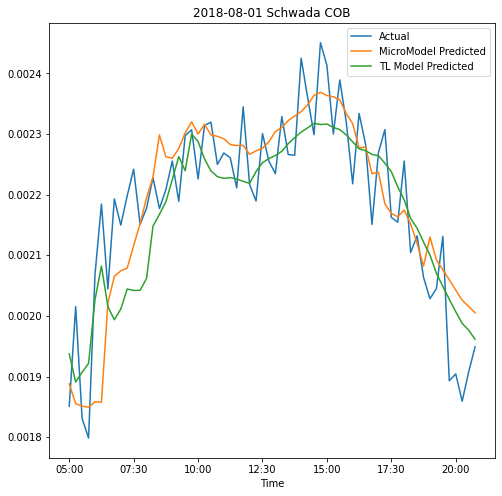

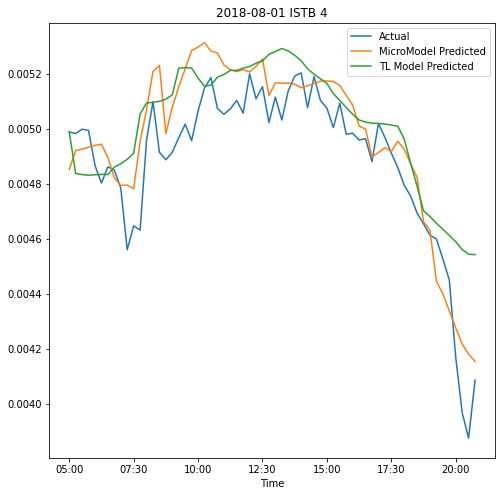

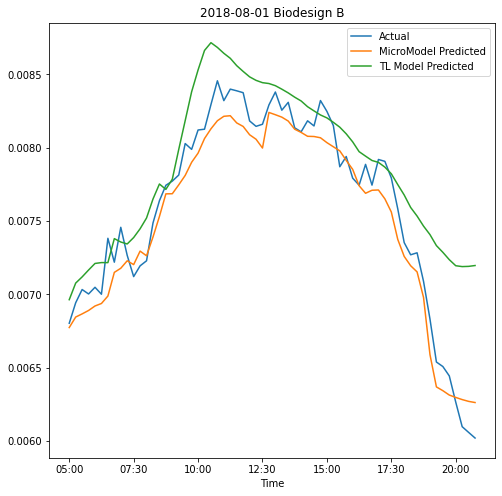

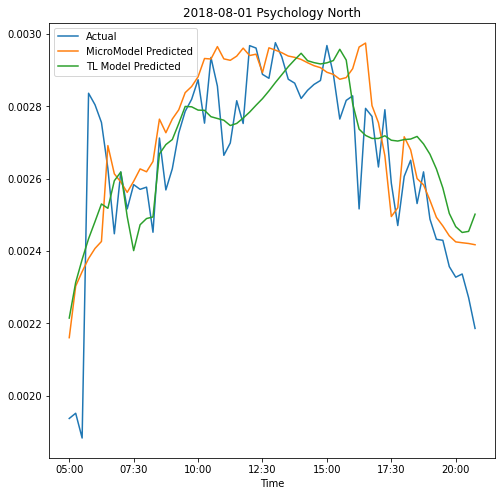

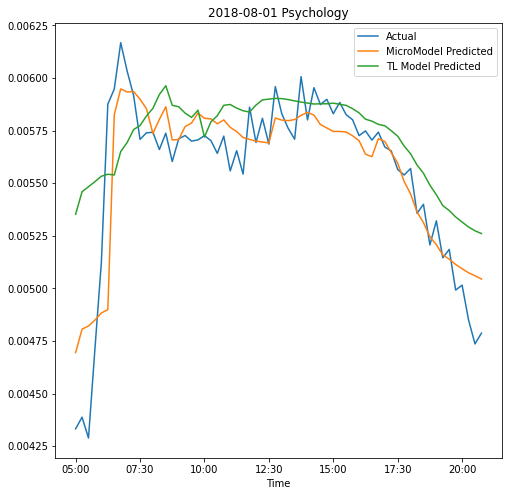

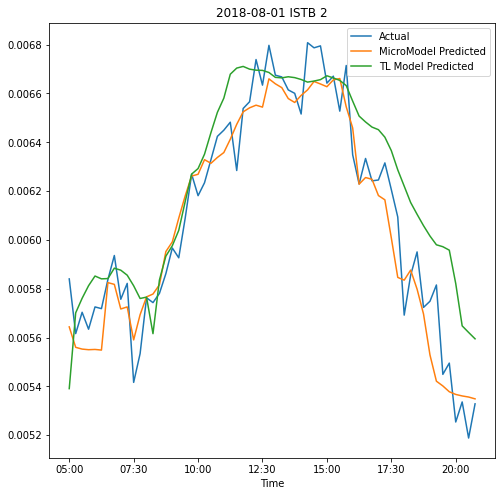

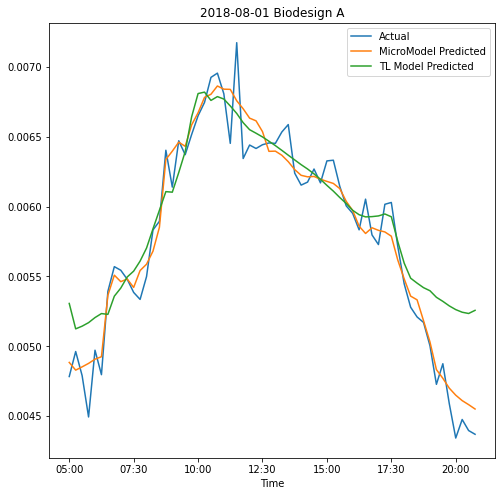

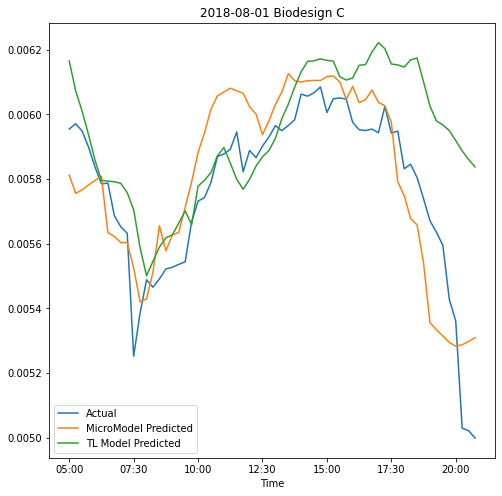

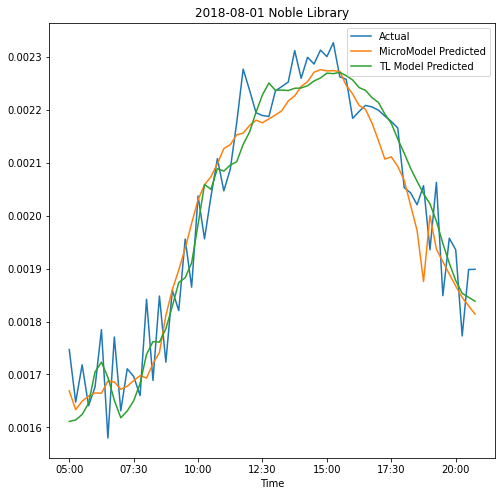

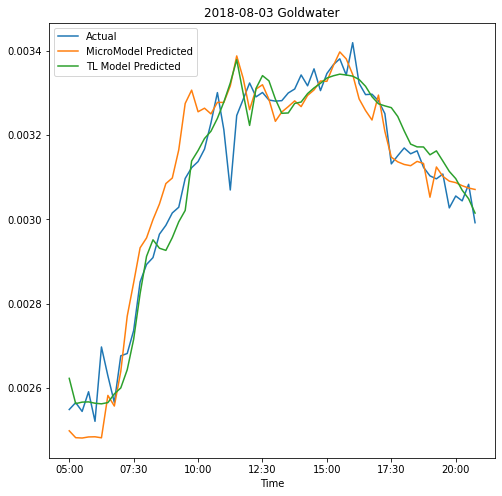

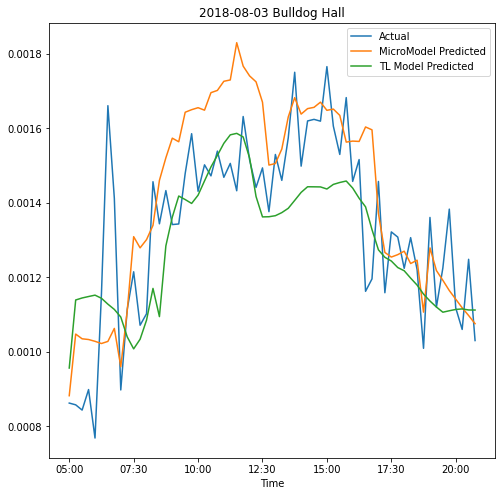

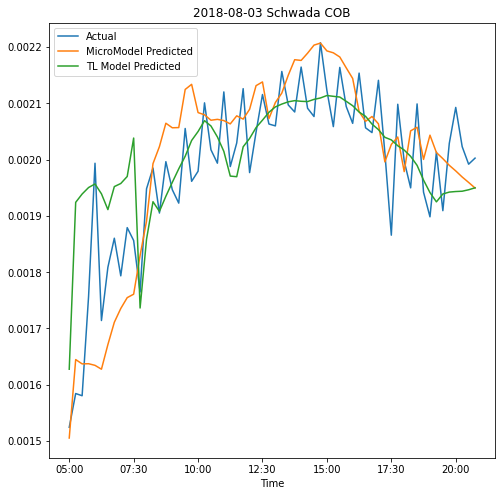

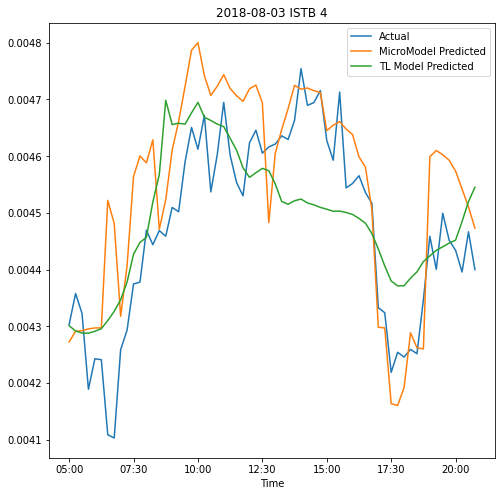

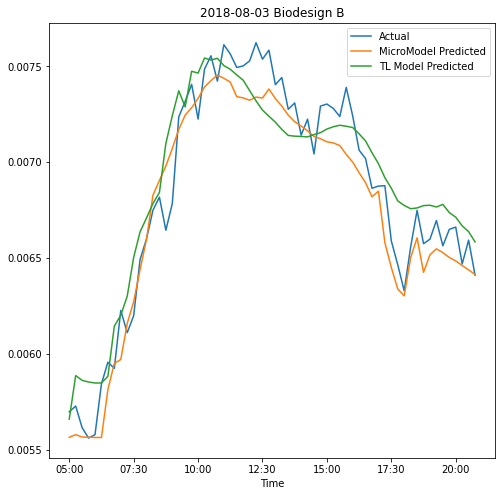

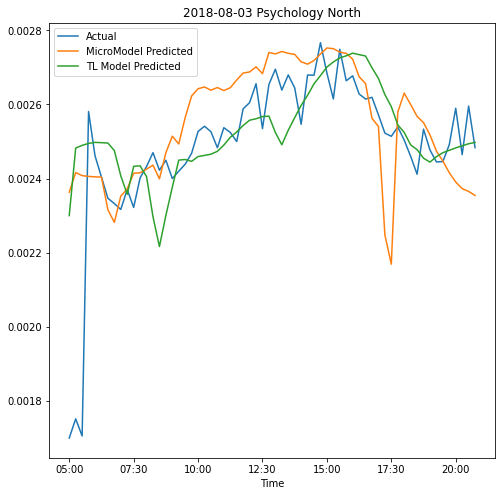

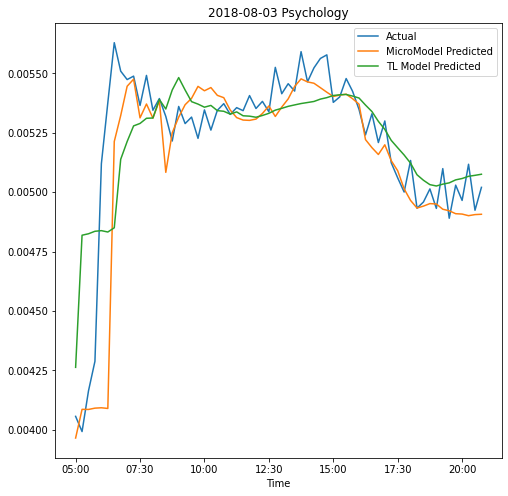

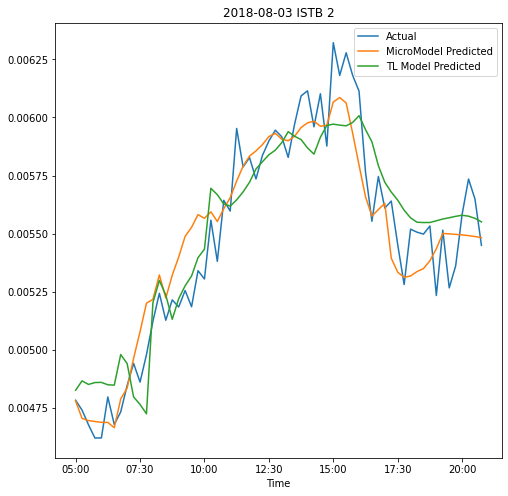

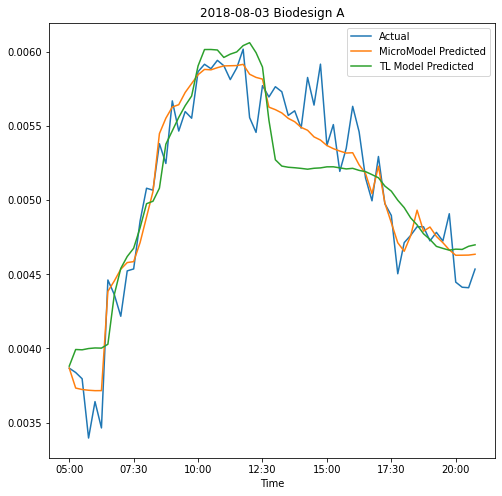

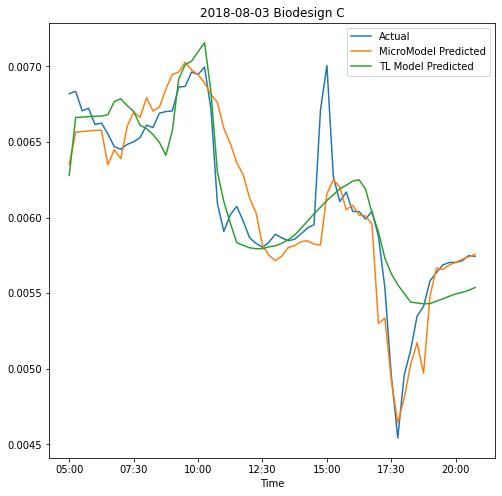

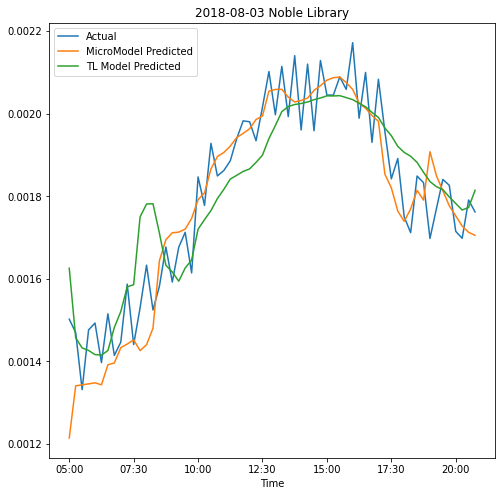

In [ ]:
## Saving the plots as files
data = MicroclimateData
for month in data['Month'].unique():
  Micro = data[data['Month']==month]
  for day in Micro['Day'].unique():
    plotResults(day,month,MicroclimateData)


In [ ]:
## Loss curves
def plot_loss_accuracy(history,text):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title(text)
    ax.grid(True)


    #ax = fig.add_subplot(1, 2, 2)
    #ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    #ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    #ax.legend()
    #ax.set_title('accuracy')
    #ax.grid(True)

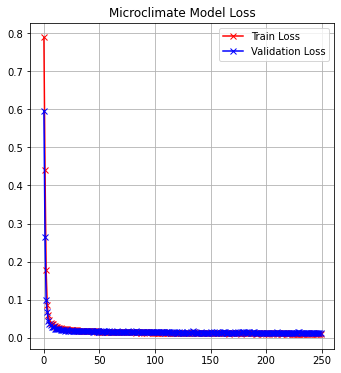

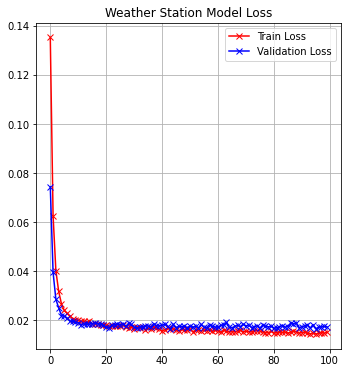

In [ ]:
plot_loss_accuracy(MicroclimateModel.history,'Microclimate Model Loss')
plot_loss_accuracy(WeatherStationModel.history, 'Weather Station Model Loss')